# Hate speech detection

In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from time import perf_counter
from collections import Counter
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import voyageai
import optuna
import re
from skimpy import skim
import emoji 
import math
import re
import nltk
from wordcloud import WordCloud
import gensim.downloader as api
import fasttext
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
tqdm.pandas()

In [2]:
nltk.download('stopwords')
wv = api.load('glove-twitter-50')

[nltk_data] Downloading package stopwords to /home/ilan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## helpfunctions for download embeddings

In [5]:
def download_csv(df : pd.DataFrame, filename : str) -> None:
    """
    Download a DataFrame as a CSV file.
    :param df: The DataFrame to download.
    :param filename: The filename to save the CSV file as.
    """
    def vector_to_json(v):
        """
        Convert a vector to a JSON string.
        :param v: The vector to convert.
        """
        if not isinstance(v, list):
            v = v.tolist()
        return json.dumps(v)
    
    df_tmp = df.copy()
    df_tmp['GloVe'] = df_tmp['GloVe'].apply(vector_to_json)
    df_tmp['FastText'] = df_tmp['FastText'].apply(vector_to_json)
    df_tmp['Voyage'] = df_tmp['Voyage'].apply(vector_to_json)

    df_tmp.to_csv(filename, index=False)

def load_csv(filename : str) -> pd.DataFrame:
    """
    Load a CSV file as a DataFrame.
    :param filename: The filename to load.
    """
    def json_to_vector(j):
        """
        Convert a JSON string to a vector.
        :param j: The JSON string to convert.
        """
        return np.array(json.loads(j))
    
    df_tmp = pd.read_csv(filename)
    df_tmp['GloVe'] = df_tmp['GloVe'].apply(json_to_vector)
    df_tmp['FastText'] = df_tmp['FastText'].apply(json_to_vector)
    df_tmp['Voyage'] = df_tmp['Voyage'].apply(json_to_vector)
    
    return df_tmp

# 1. Cleaning and visualizations

## We have a dataset of 700,000 rows, but due to time and resource constraints, I unfortunately cannot use all of this data. Therefore, we need to estimate how much data to retrieve. To do this, we will use **Hoeffding's inequality** with a tolerated error of 0.01 and a confidence level of 0.01 (which is equivalent to 99%)

## **$$ P(|\hat{p} - p| > \epsilon) \leq 2e^{-2N\epsilon^2} $$**

In [3]:
def calculate_hoeffding_samples(epsilon : float, delta : float) -> int:
    """
    Calculate the minimum number of samples required based on Hoeffding's Inequality.
    
    :param epsilon: The tolerance level (a small positive number).
    :param delta: The probability threshold for the confidence level.
    :return: The minimum number of samples required.
    """
    n = math.ceil(math.log(2/delta) / (2 * epsilon**2))
    return n

epsilon = 0.01  
delta = 0.01
n_samples = calculate_hoeffding_samples(epsilon, delta)
print(f'Minimum number of samples required: {n_samples}')


Minimum number of samples required: 26492


## We will therefore cap this value at **30,000** and retrieve a balanced sample (which means stratified in our case since the original dataset is already stratified) to work with

In [4]:
df = pd.read_csv('HateSpeechDatasetBalanced.csv')
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [5]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 726119 │ │ string      │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd     ┃ p0   ┃ p25   ┃ p50   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Label              │    0 │       0 │     0.5 │    0.5 │    0 │     0 │     1 │     1 │       1 │  ▇    ▇  │  │
│ └────────────────────┴──────┴─────────┴─────────┴────────┴──────┴───────┴───────┴───────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Content                   │       0 │          0 │                           36 │                 26383926 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

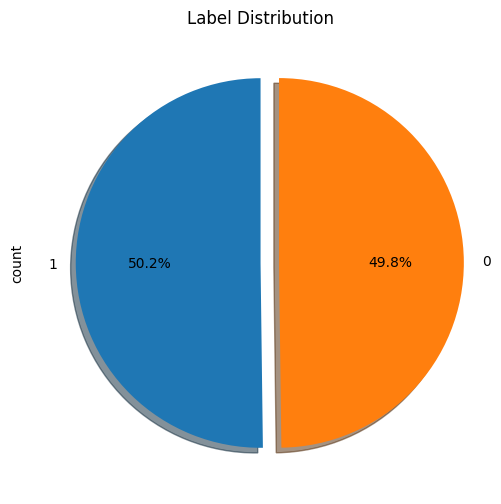

In [6]:
plt.figure(figsize=(6, 6))
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, explode=(0, 0.1), startangle=90)
plt.title('Label Distribution')
#plt.savefig('images/label_distribution_pie.png')
plt.show()

## As announced, we do indeed have a balanced dataset, and therefore we can retrieve a stratified sample of 30,000 data points

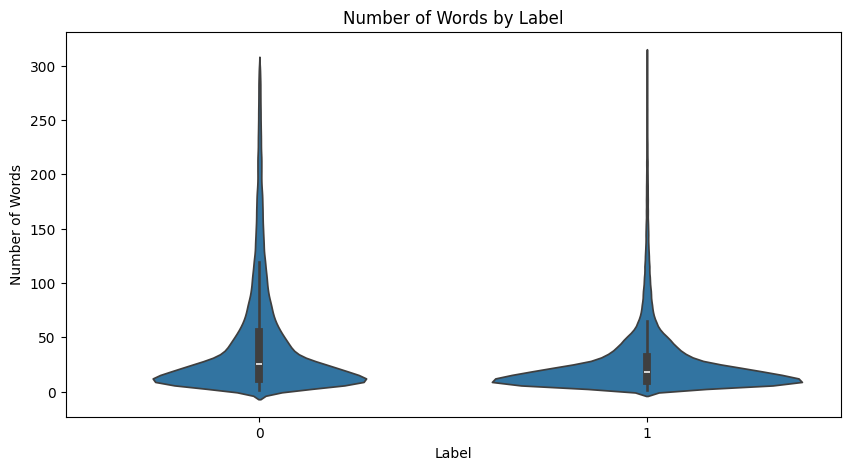

In [7]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())))
plt.title('Number of Words by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words')
#plt.savefig('images/word_count.png')
plt.show()

## The figure above shows us that most of our texts have a character count between 10 and 50. This visualization will be useful later when we need to choose a padding and truncation strategy

In [8]:
df_train, df_test = train_test_split(df, train_size=30000, stratify=df['Label'], random_state=42)
df_test, df_val = train_test_split(df_test, train_size=10000,test_size=10000, stratify=df_test['Label'], random_state=42)
df_train.to_csv('data_train.csv', index=False)
df_test.to_csv('data_test.csv', index=False)
df_val.to_csv('data_val.csv', index=False)

In [9]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')
df_val = pd.read_csv('data_val.csv')

In [10]:
df_train.isna().sum()

Content    0
Label      0
dtype: int64

In [11]:
def clean_text(text : str) -> str:
    """
    Clean the text by removing emojis, links, and special characters. Also, convert the text to lowercase, 
    remove stop words, and stem the words.
    :param text: The text to clean.
    """

    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    
    words = text.split()
    
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]
    
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [46]:
print('Cleaning text...')
print('Cleaning train set...')
df_train['Content'] = df_train['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning test set...')
df_test['Content'] = df_test['Content'].progress_apply(lambda x: clean_text(x))
print('Cleaning validation set...')
df_val['Content'] = df_val['Content'].progress_apply(lambda x: clean_text(x))
print('Done!')

Cleaning text...
Cleaning train set...


100%|██████████| 30000/30000 [00:18<00:00, 1647.40it/s]


Cleaning test set...


100%|██████████| 10000/10000 [00:06<00:00, 1621.92it/s]


Cleaning validation set...


100%|██████████| 10000/10000 [00:06<00:00, 1583.63it/s]

Done!


In [52]:
df_train = df_train[~ (df_train['Content'] == '')]
df_test = df_test[~ (df_test['Content'] == '')]
df_val = df_val[~ (df_val['Content'] == '')]


In [53]:
df_train.to_csv('data_train_cleaned.csv', index=False)
df_test.to_csv('data_test_cleaned.csv', index=False)
df_val.to_csv('data_val_cleaned.csv', index=False)

In [12]:
df_train = pd.read_csv('data_train_cleaned.csv')
df_test = pd.read_csv('data_test_cleaned.csv')
df_val = pd.read_csv('data_val_cleaned.csv')

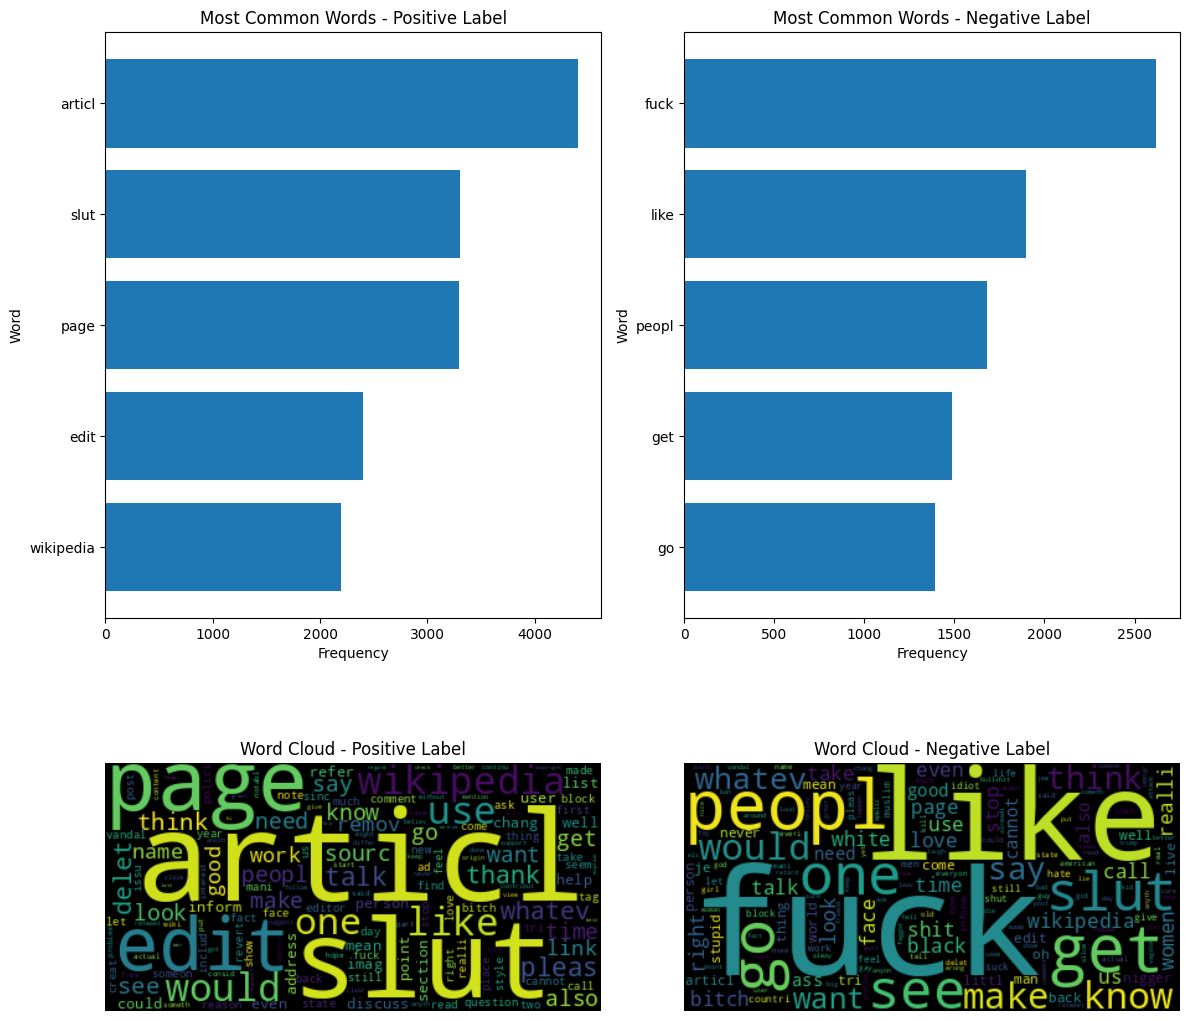

In [58]:
counter_positive = Counter(df_train[df_train['Label'] == 0]['Content'].str.split().sum())
counter_negative = Counter(df_train[df_train['Label'] == 1]['Content'].str.split().sum())

most_common_positive = counter_positive.most_common(5)[::-1]
most_common_negative = counter_negative.most_common(5)[::-1]

words_positive, frequencies_positive = zip(*most_common_positive)
words_negative, frequencies_negative = zip(*most_common_negative)

word_freq_positive = dict(counter_positive)
word_freq_negative = dict(counter_negative)

wordcloud_positive = WordCloud(background_color='black').generate_from_frequencies(word_freq_positive)
wordcloud_negative = WordCloud(background_color='black').generate_from_frequencies(word_freq_negative)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].barh(words_positive, frequencies_positive)
axs[0, 0].set_title('Most Common Words - Positive Label')
axs[0, 0].set_xlabel('Frequency')
axs[0, 0].set_ylabel('Word')

axs[0, 1].barh(words_negative, frequencies_negative)
axs[0, 1].set_title('Most Common Words - Negative Label')
axs[0, 1].set_xlabel('Frequency')
axs[0, 1].set_ylabel('Word')

axs[1, 0].imshow(wordcloud_positive, interpolation='bilinear')
axs[1, 0].set_title('Word Cloud - Positive Label')
axs[1, 0].axis('off')

axs[1, 1].imshow(wordcloud_negative, interpolation='bilinear')
axs[1, 1].set_title('Word Cloud - Negative Label')
axs[1, 1].axis('off')

# plt.savefig('images/wordcloud.png')
plt.tight_layout()
plt.show()

## The figure above shows us the most frequent words according to the label. Indeed, for negative messages, we can see an insult that is significantly more prevalent

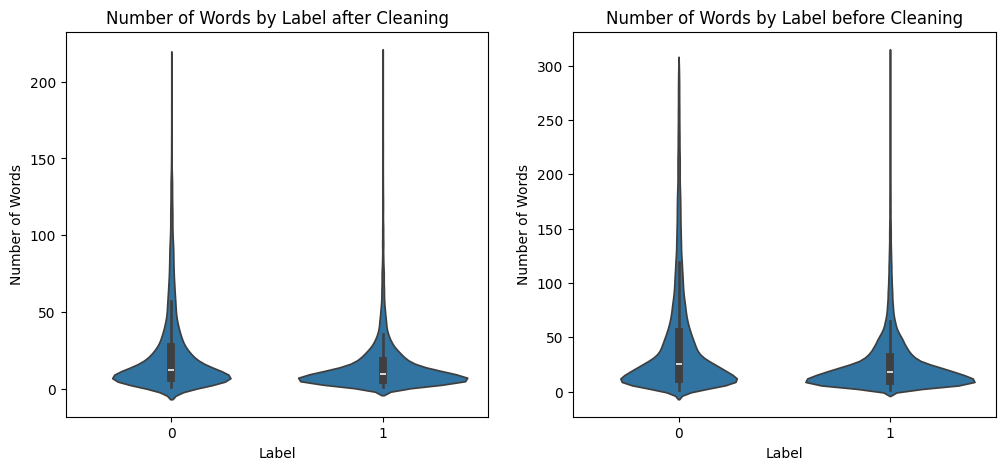

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(data=df_train, x='Label', y=df_train['Content'].apply(lambda x: len(x.split())), ax=axs[0])
axs[0].set_title('Number of Words by Label after Cleaning')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Number of Words')

sns.violinplot(data=df, x='Label', y=df['Content'].apply(lambda x: len(x.split())), ax=axs[1])
axs[1].set_title('Number of Words by Label before Cleaning')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Number of Words')

#plt.savefig('images/word_count_cleaned_vs_non_cleaned.png')
plt.show()

## The figure above compares the distribution of the number of words for each label. We inevitably gain a few words, but the distributions remain very similar

## Now we will test different methods of embedding our texts:
### 1. TF-IDF
### 2. GloVe
### 3. fasttext
### 4. Transformer (Voyage-02)

In [14]:
tfidf = TfidfVectorizer(max_features=10000)
vo = voyageai.Client(api_key = "pa-xsorIkepXUrYmSRizvQC6S9_y2mhAGALNUJCaqpe0JA")

def tokenize(text):
    return [token for token in text.split()]

def vectorize_with_gloVe(text):
  vector_size = wv.vector_size
  wv_res = np.zeros(vector_size)
  cpt = 1
  for w in text:
    if w in wv:
      cpt+=1
      wv_res += wv[w]
  wv_res = wv_res/cpt
  return wv_res    

def ft_model():
  with open('tmp.txt', 'w') as f:
    for text in df_train['Content']:
      f.write(text + '\n')
  model = fasttext.train_unsupervised('tmp.txt', model='skipgram')
  return model

ft_model = ft_model()

def vectorize_with_fasttext(text):
  return ft_model.get_sentence_vector(text)

Read 0M words
Number of words:  8346
Number of labels: 0
Progress: 100.0% words/sec/thread:   37136 lr:  0.000000 avg.loss:  2.414761 ETA:   0h 0m 0s  36897 lr:  0.022975 avg.loss:  2.450124 ETA:   0h 0m 5s


In [15]:
print('Fitting TF-IDF...')
docs_tf_idf = tfidf.fit_transform(df_train['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove = df_train['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft = df_train['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched = [df_train['Content'][i:i + 50].tolist() for i in range(0, len(df_train['Content']), 50)]
docs_voyage = []
for batch in tqdm(docs_batched):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 29956/29956 [00:01<00:00, 15296.78it/s]


Done!
Embedding with FastText...


100%|██████████| 29956/29956 [00:03<00:00, 9593.89it/s] 


Done!
Embedding with Voyage...


100%|██████████| 600/600 [06:06<00:00,  1.64it/s]

Done!


In [16]:
print('Length of TF-IDF vectors:', len(docs_tf_idf[0]))
print('Length of GloVe vectors:', len(docs_glove[0]))
print('Length of FastText vectors:', len(docs_ft[0]))
print('Length of Voyage vectors:', len(docs_voyage[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf))
print('Number of GloVe vectors:', len(docs_glove))
print('Number of FastText vectors:', len(docs_ft))
print('Number of Voyage vectors:', len(docs_voyage))

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 29956
Number of GloVe vectors: 29956
Number of FastText vectors: 29956
Number of Voyage vectors: 29956


In [23]:
df_with_vectors = df_train.copy()

#df_with_vectors['TF-IDF'] = docs_tf_idf.tolist()
df_with_vectors['GloVe'] = docs_glove
df_with_vectors['FastText'] = docs_ft
df_with_vectors['Voyage'] = docs_voyage

download_csv(df_with_vectors, 'data_train_with_vectors.csv')

In [6]:
df_with_vectors = load_csv('data_train_with_vectors.csv')

In [25]:
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)
embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']
df_dict = {}

for embed in tqdm(embed_list):
    if embed == 'TF-IDF':
        tmp_feat = svd.fit_transform(docs_tf_idf)
    else:
        tmp_feat = pca.fit_transform(df_with_vectors[embed].tolist())
    df_dict[embed] = pd.DataFrame({'X1': tmp_feat[:, 0], 'X2': tmp_feat[:, 1], 'Label': df_with_vectors['Label']})

100%|██████████| 4/4 [00:14<00:00,  3.55s/it]


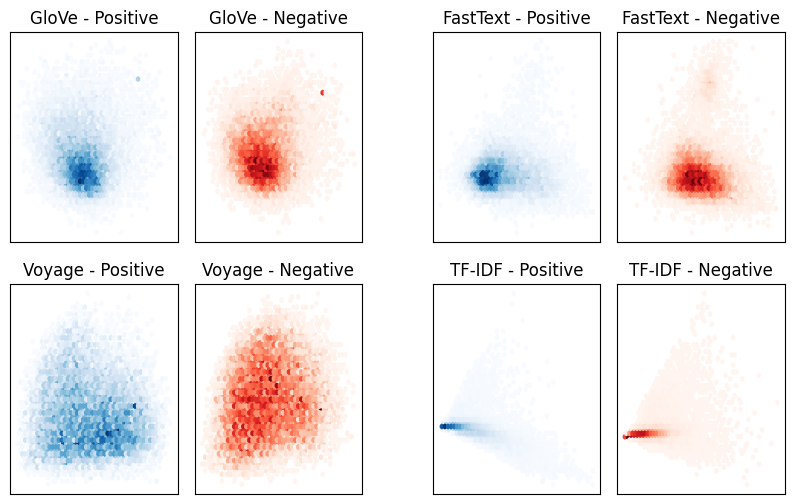

In [45]:
fig = plt.figure(figsize=(10, 6))

outer_grid = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

for i, (embed, df) in enumerate(df_dict.items()):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.1)
    
    df_0 = df[df['Label'] == 0]
    df_1 = df[df['Label'] == 1]

    for j in range(2):
        ax = plt.Subplot(fig, inner_grid[j])
        fig.add_subplot(ax)
        
        if j == 0:
            ax.hexbin(df_0['X1'], df_0['X2'], gridsize=50, cmap='Blues', mincnt=1)
            ax.set_title(f'{embed} - Positive')
        else:
            ax.hexbin(df_1['X1'], df_1['X2'], gridsize=50, cmap='Reds', mincnt=1)
            ax.set_title(f'{embed} - Negative')
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)

#plt.savefig('images/embeddings_pca.png')
plt.show()


## Although it is subtle, we still notice trends in orientation depending on the label, especially for `voyage` and `fasttext`

# 2. Modeling
### For the metrics, we will use everything that is specific to classification (`accuracy`, `precision`, `recall`, `f1`, `confusion matrix`). Accuracy is relevant due to the balance of our data

### We must first prepare the test and validation sets

In [30]:
print('Fitting TF-IDF...')
docs_tf_idf_test = tfidf.fit_transform(df_test['Content']).toarray()
docs_tf_idf_val = tfidf.fit_transform(df_val['Content']).toarray()
print('Done!')
print('Embedding with GloVe...')
docs_glove_test = df_test['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
docs_glove_val = df_val['Content'].progress_apply(lambda x: vectorize_with_gloVe(tokenize(x))).tolist()
print('Done!')
print('Embedding with FastText...')
docs_ft_test = df_test['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
docs_ft_val = df_val['Content'].progress_apply(lambda x: vectorize_with_fasttext(x)).tolist()
print('Done!')
print('Embedding with Voyage...')
docs_batched_test = [df_test['Content'][i:i + 50].tolist() for i in range(0, len(df_test['Content']), 50)]
docs_voyage_test = []
for batch in tqdm(docs_batched_test):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_test.extend(batch_embeddings)
docs_batched_val = [df_val['Content'][i:i + 50].tolist() for i in range(0, len(df_val['Content']), 50)]
docs_voyage_val = []
for batch in tqdm(docs_batched_val):
    try:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    except:
        batch_embeddings = vo.embed(batch, model='voyage-02', input_type='document').embeddings
    finally:
        docs_voyage_val.extend(batch_embeddings)
print('Done!')

Fitting TF-IDF...
Done!
Embedding with GloVe...


100%|██████████| 9984/9984 [00:00<00:00, 14093.78it/s]


Done!
Embedding with FastText...


100%|██████████| 9984/9984 [00:01<00:00, 9534.70it/s]


Done!
Embedding with Voyage...


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]

Done!


In [31]:
print('Test Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_test[0]))
print('Length of GloVe vectors:', len(docs_glove_test[0]))
print('Length of FastText vectors:', len(docs_ft_test[0]))
print('Length of Voyage vectors:', len(docs_voyage_test[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_test))
print('Number of GloVe vectors:', len(docs_glove_test))
print('Number of FastText vectors:', len(docs_ft_test))
print('Number of Voyage vectors:', len(docs_voyage_test))
print('\n\n')
print('Validation Set Embeddings Shape', end='\n\n')
print('Length of TF-IDF vectors:', len(docs_tf_idf_val[0]))
print('Length of GloVe vectors:', len(docs_glove_val[0]))
print('Length of FastText vectors:', len(docs_ft_val[0]))
print('Length of Voyage vectors:', len(docs_voyage_val[0]))
print()
print('Number of TF-IDF vectors:', len(docs_tf_idf_val))
print('Number of GloVe vectors:', len(docs_glove_val))
print('Number of FastText vectors:', len(docs_ft_val))
print('Number of Voyage vectors:', len(docs_voyage_val))

Test Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9987
Number of GloVe vectors: 9987
Number of FastText vectors: 9987
Number of Voyage vectors: 9987



Validation Set Embeddings Shape

Length of TF-IDF vectors: 10000
Length of GloVe vectors: 50
Length of FastText vectors: 100
Length of Voyage vectors: 1024

Number of TF-IDF vectors: 9984
Number of GloVe vectors: 9984
Number of FastText vectors: 9984
Number of Voyage vectors: 9984


In [32]:
df_with_vectors_test = df_test.copy()
#df_with_vectors_test['TF-IDF'] = docs_tf_idf_test.tolist()
df_with_vectors_test['GloVe'] = docs_glove_test
df_with_vectors_test['FastText'] = docs_ft_test
df_with_vectors_test['Voyage'] = docs_voyage_test
download_csv(df_with_vectors_test, 'data_test_with_vectors.csv')

df_with_vectors_val = df_val.copy()
#df_with_vectors_val['TF-IDF'] = docs_tf_idf_val.tolist()
df_with_vectors_val['GloVe'] = docs_glove_val
df_with_vectors_val['FastText'] = docs_ft_val
df_with_vectors_val['Voyage'] = docs_voyage_val
download_csv(df_with_vectors_val, 'data_val_with_vectors.csv')

In [7]:
df_with_vectors_test = load_csv('data_test_with_vectors.csv')
df_with_vectors_val = load_csv('data_val_with_vectors.csv')

In [36]:
df_with_vectors.head()

,Content,Label,GloVe,FastText,Voyage
0,merg discuss slut merg discuss page ever held ...,0,"[0.396307966417887, 0.3437552653591741, 0.1330...","[0.013699262402951717, 0.00045087654143571854,...","[0.020471060648560524, 0.003549023065716028, -..."
1,dunno look okay like,0,"[0.23359980136156083, 0.12730599641799928, 0.1...","[-0.028239358216524124, 0.06274276971817017, 0...","[0.014980827458202839, 0.0034704094287008047, ..."
2,ipak odustajem haha hahaha,0,"[0.8878275007009506, 0.22010250389575958, 0.32...","[-0.009178552776575089, 0.0492682047188282, 0....","[0.013682648539543152, 0.019817529246211052, -..."
3,moslem terrorist rather vigilant killer whale,1,"[-0.35405429133347105, 0.21748528948851995, -0...","[-0.045700207352638245, 0.0079624829813838, -0...","[0.022014306858181953, 0.004979489371180534, -..."
4,meant claim fuck boi bwhahhahahaha,1,"[0.33812599182128905, 0.3702240020036697, -0.0...","[-0.0728086456656456, -0.007704657502472401, 0...","[0.023333314806222916, 0.00996093638241291, -0..."


In [34]:
df_with_vectors_test.head()

,Content,Label,GloVe,FastText,Voyage
0,life differ one anoth son,1,"[0.05341993241260449, 0.020065002143383026, -0...","[-0.015524527989327908, -0.016127189621329308,...","[0.024511517956852913, 0.010551409795880318, -..."
1,ooh worth capricorncapricorn crystal silver ba...,1,"[-0.24783592258030787, -0.24551213227021387, 0...","[-0.056029368191957474, 0.04141700267791748, 0...","[0.044766977429389954, -0.016489360481500626, ..."
2,real lupus erythematosus hope peopl hither rea...,1,"[-0.06895894748676154, 0.013367330034573873, -...","[-0.01760084368288517, 0.01128313597291708, 0....","[-0.0010086046531796455, 0.01235181838274002, ..."
3,page use hi hi know discuss close still show p...,0,"[0.5058850753121078, 0.22819341346621513, 0.03...","[0.027371583506464958, 0.1063939556479454, 0.0...","[0.006542394403368235, 0.00820163358002901, -0..."
4,ford knew moment came forward anonym name woul...,1,"[0.0809733620421453, 0.18893477526690924, 0.13...","[-0.00885710772126913, 0.01862104795873165, 0....","[0.005794798023998737, 0.013458643108606339, -..."


In [35]:
df_with_vectors_val.head()

,Content,Label,GloVe,FastText,Voyage
0,hour midnight said call girl awkward,0,"[0.03305572058473315, 0.4437462772641863, 0.18...","[-0.031698163598775864, 0.0775686651468277, 0....","[-0.004964085761457682, 0.009776967577636242, ..."
1,defund action send inaugur,1,"[0.15838724840432405, 0.56615000218153, -0.049...","[-0.010622715577483177, -0.03983072191476822, ...","[0.015210222452878952, 0.012634547427296638, -..."
2,also scientif evid err safe side whatev need m...,1,"[0.026012308035905544, 0.1344436131990873, -0....","[0.007599100936204195, 0.02113112062215805, 0....","[0.00793453585356474, 0.0017771729035302997, -..."
3,serious say think truth starter one ignor pric...,1,"[0.24492387050906053, 0.22207846194326591, -0....","[-0.018434209749102592, 0.017132332548499107, ...","[0.01141525711864233, -0.027929048985242844, -..."
4,often ad coverag major miss viewpoint prefer t...,0,"[0.26919693098618436, 0.30409315185478103, 0.1...","[0.004747851751744747, 0.010076402686536312, 0...","[-0.010252219624817371, -0.004589424934238195,..."


## First, we will build our initial models using the embeddings we have.

### First, we will try the naive Bayes models. 

In [73]:
# Multinomial Naive Bayes & Bernoulli Naive Bayes are used for TF-IDF vectors
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()

In [80]:
model_scores = {
    'Multinomial Naive Bayes': {embed: {} for embed in embed_list},
    'Gaussian Naive Bayes': {embed: {} for embed in embed_list},
    'Bernoulli Naive Bayes': {embed: {} for embed in embed_list},
}

In [81]:
for embed in tqdm(embed_list):
    y_train = df_with_vectors['Label'].tolist()
    y_test = df_with_vectors_test['Label'].tolist()
    if embed == 'TF-IDF':
        X_train = docs_tf_idf
        mnb.fit(X_train, y_train)
        bnb.fit(X_train, y_train)
        X_test = docs_tf_idf_test
        start = perf_counter()
        preds = mnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Multinomial Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Multinomial Naive Bayes']['TF-IDF']['time'] = end

        start = perf_counter()
        preds = bnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['f1'] = f1_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['precision'] = precision_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['recall'] = recall_score(y_test, preds)
        model_scores['Bernoulli Naive Bayes']['TF-IDF']['time'] = end
    else:
        X_train = df_with_vectors[embed].tolist()
        gnb.fit(X_train, y_train)
        X_test = df_with_vectors_test[embed].tolist()
        start = perf_counter()
        preds = gnb.predict(X_test)
        end = perf_counter() - start
        model_scores['Gaussian Naive Bayes'][embed]['accuracy'] = accuracy_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['f1'] = f1_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['precision'] = precision_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['recall'] = recall_score(y_test, preds)
        model_scores['Gaussian Naive Bayes'][embed]['time'] = end

100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


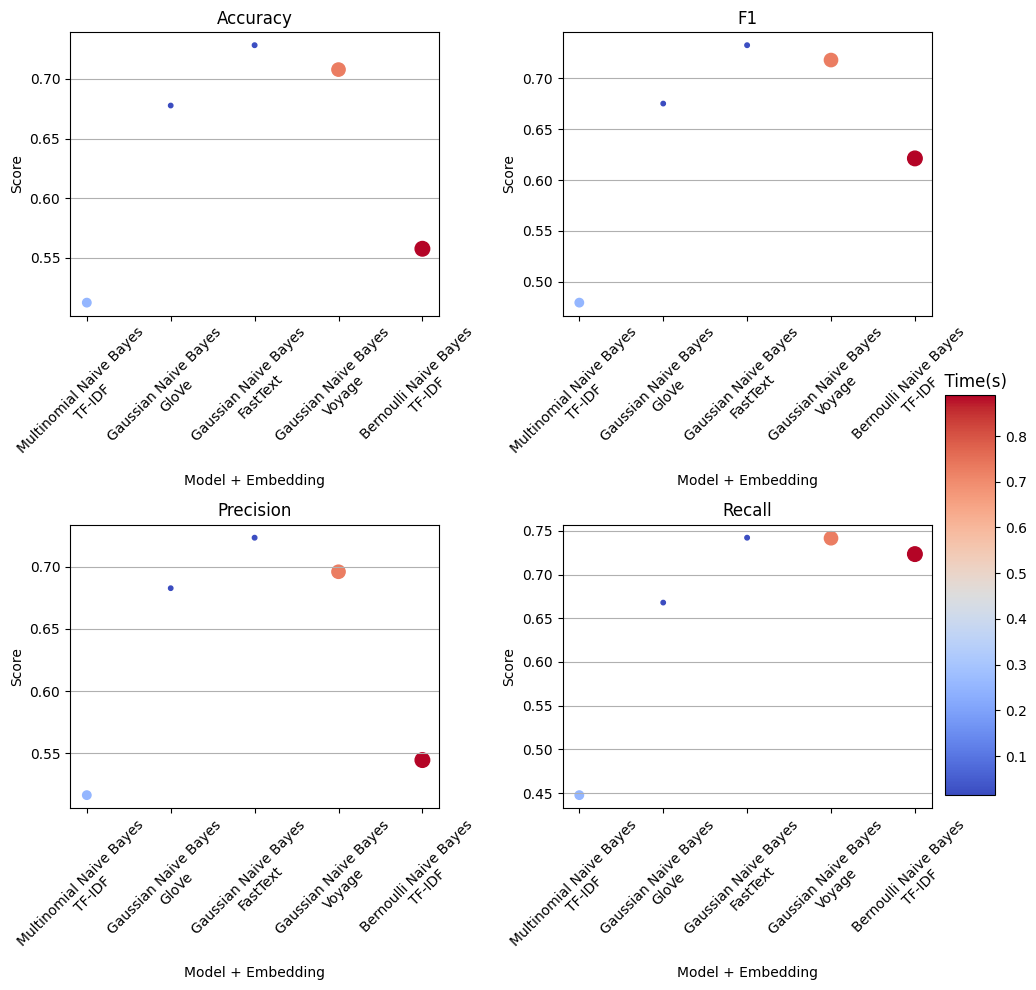

In [129]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

metrics = ['accuracy', 'f1', 'precision', 'recall']
model_embeddings = []
scores = {metric: [] for metric in metrics}
times = []

for model in model_scores:
    for embed in model_scores[model]:
        if not model_scores[model][embed]:
            continue

        model_embeddings.append(f"{model}\n{embed}")
        for metric in metrics:
            scores[metric].append(model_scores[model][embed].get(metric, None))
        times.append(model_scores[model][embed].get('time', None))

clean_indices = [i for i, t in enumerate(times) if t is not None]
model_embeddings = [model_embeddings[i] for i in clean_indices]
times = [times[i] for i in clean_indices]
for metric in metrics:
    scores[metric] = [scores[metric][i] for i in clean_indices]

times = np.array(times)
sizes = (times - times.min()) / (times.max() - times.min()) * 100 + 10  

for ax, metric in zip(axs, metrics):
    sc = ax.scatter(model_embeddings, scores[metric], c=times, cmap='coolwarm', s=sizes)
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Model + Embedding')
    ax.set_ylabel('Score')
    ax.set_xticklabels(model_embeddings, rotation=45)
    ax.grid(True, axis='y')

cbar = fig.colorbar(sc, ax=axs, cax=fig.add_axes([0.95, 0.2, 0.05, 0.4]), aspect=10)
cbar.ax.set_title('  Time(s)')

plt.tight_layout()
plt.savefig('images/naive_bayes.png')
plt.show()

### We notice that among the four metrics, the model performing the best is `FastText+GaussianNB`. It has the best inference time and the best results. We can note the slowness of inference with the Voyage embeddings, in addition to the fact that their performance does not surpass that of GloVe by much. **Let's recall the embeddings sizes (50 for GloVe and 1024 for Voyage-02)**

## Now we are going to try some classic machine learning algorithms: `SVM` `LogisticRegression` `RandomForest` `XGBoost`

### We will need to optimize the hyperparameters, and to do this we will use `Optuna`

In [8]:
# SGDCLassifier with hinge loss (SVM).

embed_list = ['GloVe', 'FastText', 'Voyage','TF-IDF']

df_with_vectors_with_val = pd.concat([df_with_vectors, df_with_vectors_val], ignore_index=True)

def svm_objective(trial, docs_train):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'tol': trial.suggest_loguniform('tol', 1e-5, 1e-1),
        'loss': 'hinge',
        'random_state': 42
    }
    model = SGDClassifier(**params)
    scores = cross_val_score(model, docs_train, df_with_vectors_with_val['Label'], cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name='SGDClassifier SVM')

[I 2024-01-28 12:55:35,210] A new study created in memory with name: SGDClassifier SVM


In [9]:
sgd_best_params = {embed: {} for embed in embed_list}
study_list = []

for embed in embed_list:
    if embed == 'TF-IDF':
        continue
    else:
        print(f'----- {embed} -----', end='\n\n')
        study = optuna.create_study(direction='maximize')

        study.optimize(lambda trial: svm_objective(trial, df_with_vectors_with_val[embed].tolist()), n_trials=50, show_progress_bar=True)

        sgd_best_params[embed] = study.best_params

        study_list.append(study)

[I 2024-01-28 12:56:30,353] A new study created in memory with name: no-name-0060beb7-d236-4b9a-b0d4-0f373139b08f


----- GloVe -----



Best trial: 0. Best value: 0.695794:   2%|▏         | 1/50 [00:06<05:26,  6.66s/it]

[I 2024-01-28 12:56:37,013] Trial 0 finished with value: 0.6957936905358038 and parameters: {'alpha': 0.06864520451955526, 'penalty': 'elasticnet', 'max_iter': 4540, 'tol': 0.0004910586633123176}. Best is trial 0 with value: 0.6957936905358038.


Best trial: 1. Best value: 0.708062:   4%|▍         | 2/50 [00:11<04:25,  5.54s/it]

[I 2024-01-28 12:56:41,763] Trial 1 finished with value: 0.7080620931397096 and parameters: {'alpha': 0.0049070852627151945, 'penalty': 'l1', 'max_iter': 1717, 'tol': 0.04864419573472735}. Best is trial 1 with value: 0.7080620931397096.


Best trial: 1. Best value: 0.708062:   6%|▌         | 3/50 [00:17<04:27,  5.70s/it]

[I 2024-01-28 12:56:47,649] Trial 2 finished with value: 0.6803204807210815 and parameters: {'alpha': 2.36953233718762e-05, 'penalty': 'l1', 'max_iter': 1564, 'tol': 8.257953323206062e-05}. Best is trial 1 with value: 0.7080620931397096.


Best trial: 3. Best value: 0.712569:   8%|▊         | 4/50 [00:22<04:13,  5.51s/it]

[I 2024-01-28 12:56:52,884] Trial 3 finished with value: 0.7125688532799198 and parameters: {'alpha': 7.800167901156322e-05, 'penalty': 'l1', 'max_iter': 4429, 'tol': 0.0007654775752317599}. Best is trial 3 with value: 0.7125688532799198.


Best trial: 4. Best value: 0.713545:  10%|█         | 5/50 [00:27<03:54,  5.21s/it]

[I 2024-01-28 12:56:57,563] Trial 4 finished with value: 0.7135453179769655 and parameters: {'alpha': 0.0009353925108918028, 'penalty': 'l2', 'max_iter': 2295, 'tol': 2.312965608027346e-05}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  12%|█▏        | 6/50 [00:32<03:46,  5.14s/it]

[I 2024-01-28 12:57:02,569] Trial 5 finished with value: 0.6633450175262894 and parameters: {'alpha': 2.2275955736617485e-05, 'penalty': 'elasticnet', 'max_iter': 1571, 'tol': 0.004350139223253536}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  14%|█▍        | 7/50 [00:36<03:34,  4.98s/it]

[I 2024-01-28 12:57:07,220] Trial 6 finished with value: 0.7118427641462194 and parameters: {'alpha': 0.0017159266361387725, 'penalty': 'l2', 'max_iter': 4550, 'tol': 0.0003850282575973555}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  16%|█▌        | 8/50 [00:41<03:25,  4.90s/it]

[I 2024-01-28 12:57:11,931] Trial 7 finished with value: 0.7034551827741613 and parameters: {'alpha': 0.008850560607941082, 'penalty': 'l1', 'max_iter': 3490, 'tol': 0.000507239622368352}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  18%|█▊        | 9/50 [00:46<03:14,  4.76s/it]

[I 2024-01-28 12:57:16,380] Trial 8 finished with value: 0.7115923885828743 and parameters: {'alpha': 0.00022306052121281035, 'penalty': 'elasticnet', 'max_iter': 3827, 'tol': 0.017466541343877935}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  20%|██        | 10/50 [00:50<03:11,  4.79s/it]

[I 2024-01-28 12:57:21,247] Trial 9 finished with value: 0.7110665998998498 and parameters: {'alpha': 0.00033397260362782116, 'penalty': 'l1', 'max_iter': 3095, 'tol': 0.0005366613791822439}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  22%|██▏       | 11/50 [00:55<03:03,  4.71s/it]

[I 2024-01-28 12:57:25,779] Trial 10 finished with value: 0.7096394591887831 and parameters: {'alpha': 0.04724276305196948, 'penalty': 'l2', 'max_iter': 2390, 'tol': 1.089411145184473e-05}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  24%|██▍       | 12/50 [01:00<02:59,  4.72s/it]

[I 2024-01-28 12:57:30,526] Trial 11 finished with value: 0.7117676514772159 and parameters: {'alpha': 0.00013532054620190594, 'penalty': 'l2', 'max_iter': 2508, 'tol': 1.4767644226395123e-05}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 4. Best value: 0.713545:  26%|██▌       | 13/50 [01:05<02:58,  4.82s/it]

[I 2024-01-28 12:57:35,583] Trial 12 finished with value: 0.7106409614421632 and parameters: {'alpha': 7.982200514367929e-05, 'penalty': 'l2', 'max_iter': 2279, 'tol': 6.836596735275908e-05}. Best is trial 4 with value: 0.7135453179769655.


Best trial: 13. Best value: 0.714347:  28%|██▊       | 14/50 [01:09<02:47,  4.66s/it]

[I 2024-01-28 12:57:39,856] Trial 13 finished with value: 0.7143465197796695 and parameters: {'alpha': 0.0008066587005690594, 'penalty': 'l1', 'max_iter': 4971, 'tol': 0.004430292631286913}. Best is trial 13 with value: 0.7143465197796695.


Best trial: 14. Best value: 0.715298:  30%|███       | 15/50 [01:13<02:37,  4.50s/it]

[I 2024-01-28 12:57:44,006] Trial 14 finished with value: 0.7152979469203805 and parameters: {'alpha': 0.0007547411045144002, 'penalty': 'l2', 'max_iter': 4934, 'tol': 0.003576780383747272}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  32%|███▏      | 16/50 [01:17<02:28,  4.37s/it]

[I 2024-01-28 12:57:48,076] Trial 15 finished with value: 0.7145468202303454 and parameters: {'alpha': 0.0009901498725410722, 'penalty': 'l1', 'max_iter': 4945, 'tol': 0.005054123357450788}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  34%|███▍      | 17/50 [01:21<02:20,  4.25s/it]

[I 2024-01-28 12:57:52,052] Trial 16 finished with value: 0.713720580871307 and parameters: {'alpha': 0.004231997476367292, 'penalty': 'l2', 'max_iter': 3952, 'tol': 0.0037411219447470176}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  36%|███▌      | 18/50 [01:25<02:13,  4.16s/it]

[I 2024-01-28 12:57:55,987] Trial 17 finished with value: 0.7112168252378568 and parameters: {'alpha': 0.019336788652294556, 'penalty': 'l2', 'max_iter': 4972, 'tol': 0.012536185564329371}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  38%|███▊      | 19/50 [01:29<02:09,  4.19s/it]

[I 2024-01-28 12:58:00,252] Trial 18 finished with value: 0.7117926890335504 and parameters: {'alpha': 0.002465636607962191, 'penalty': 'l1', 'max_iter': 4025, 'tol': 0.002408760802036672}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  40%|████      | 20/50 [01:33<02:04,  4.15s/it]

[I 2024-01-28 12:58:04,301] Trial 19 finished with value: 0.7113169754631947 and parameters: {'alpha': 0.0005109568749526683, 'penalty': 'elasticnet', 'max_iter': 3394, 'tol': 0.07980058164661528}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  42%|████▏     | 21/50 [01:38<02:03,  4.25s/it]

[I 2024-01-28 12:58:08,783] Trial 20 finished with value: 0.6935903855783676 and parameters: {'alpha': 0.015143518689469174, 'penalty': 'l1', 'max_iter': 1041, 'tol': 0.014303611288851745}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  44%|████▍     | 22/50 [01:42<01:59,  4.27s/it]

[I 2024-01-28 12:58:13,120] Trial 21 finished with value: 0.7126940410615925 and parameters: {'alpha': 0.0007007348997285212, 'penalty': 'l1', 'max_iter': 4920, 'tol': 0.0019864733526866597}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  46%|████▌     | 23/50 [01:46<01:54,  4.26s/it]

[I 2024-01-28 12:58:17,335] Trial 22 finished with value: 0.7098647971957937 and parameters: {'alpha': 0.0016187445602570893, 'penalty': 'l1', 'max_iter': 4322, 'tol': 0.006403971283271104}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  48%|████▊     | 24/50 [01:51<01:52,  4.34s/it]

[I 2024-01-28 12:58:21,870] Trial 23 finished with value: 0.7152729093640461 and parameters: {'alpha': 0.0003035838914161895, 'penalty': 'l1', 'max_iter': 4825, 'tol': 0.0013980571481734042}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  50%|█████     | 25/50 [01:56<01:53,  4.52s/it]

[I 2024-01-28 12:58:26,815] Trial 24 finished with value: 0.713169754631948 and parameters: {'alpha': 0.00024908439468729294, 'penalty': 'l1', 'max_iter': 4633, 'tol': 0.0001513352788383615}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  52%|█████▏    | 26/50 [02:01<01:49,  4.55s/it]

[I 2024-01-28 12:58:31,424] Trial 25 finished with value: 0.7123435152729094 and parameters: {'alpha': 7.561002318678011e-05, 'penalty': 'l2', 'max_iter': 4174, 'tol': 0.0015224603206531603}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  54%|█████▍    | 27/50 [02:05<01:41,  4.41s/it]

[I 2024-01-28 12:58:35,518] Trial 26 finished with value: 0.7079118678017026 and parameters: {'alpha': 0.00042691624916208333, 'penalty': 'l1', 'max_iter': 4703, 'tol': 0.029890640216313036}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  56%|█████▌    | 28/50 [02:09<01:36,  4.38s/it]

[I 2024-01-28 12:58:39,826] Trial 27 finished with value: 0.6905358037055583 and parameters: {'alpha': 0.00015758719818454345, 'penalty': 'l1', 'max_iter': 3711, 'tol': 0.008887439220141439}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  58%|█████▊    | 29/50 [02:15<01:41,  4.82s/it]

[I 2024-01-28 12:58:45,675] Trial 28 finished with value: 0.6997245868803205 and parameters: {'alpha': 1.0764034226604238e-05, 'penalty': 'elasticnet', 'max_iter': 4189, 'tol': 0.00022138642819613118}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  60%|██████    | 30/50 [02:19<01:31,  4.58s/it]

[I 2024-01-28 12:58:49,695] Trial 29 finished with value: 0.7115923885828743 and parameters: {'alpha': 0.002718531449835331, 'penalty': 'l2', 'max_iter': 4733, 'tol': 0.0011297987596457226}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  62%|██████▏   | 31/50 [02:23<01:24,  4.45s/it]

[I 2024-01-28 12:58:53,840] Trial 30 finished with value: 0.7143465197796696 and parameters: {'alpha': 0.001390637586679634, 'penalty': 'elasticnet', 'max_iter': 4403, 'tol': 0.0022871858351278997}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  64%|██████▍   | 32/50 [02:27<01:19,  4.44s/it]

[I 2024-01-28 12:58:58,242] Trial 31 finished with value: 0.7151226840260392 and parameters: {'alpha': 0.0014232214950521543, 'penalty': 'elasticnet', 'max_iter': 4500, 'tol': 0.0023239270064125623}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  66%|██████▌   | 33/50 [02:32<01:15,  4.44s/it]

[I 2024-01-28 12:59:02,686] Trial 32 finished with value: 0.7130445668502754 and parameters: {'alpha': 0.005552404019207981, 'penalty': 'elasticnet', 'max_iter': 4727, 'tol': 0.0009849658019706563}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  68%|██████▊   | 34/50 [02:36<01:11,  4.45s/it]

[I 2024-01-28 12:59:07,167] Trial 33 finished with value: 0.7104656985478217 and parameters: {'alpha': 0.0005486781916121911, 'penalty': 'elasticnet', 'max_iter': 4933, 'tol': 0.026079230063886114}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  70%|███████   | 35/50 [02:41<01:06,  4.46s/it]

[I 2024-01-28 12:59:11,656] Trial 34 finished with value: 0.7121181772658989 and parameters: {'alpha': 0.0011423745408835565, 'penalty': 'elasticnet', 'max_iter': 4468, 'tol': 0.007023385753163758}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  72%|███████▏  | 36/50 [02:45<01:01,  4.40s/it]

[I 2024-01-28 12:59:15,901] Trial 35 finished with value: 0.7096394591887831 and parameters: {'alpha': 0.003855647713956722, 'penalty': 'l1', 'max_iter': 4281, 'tol': 0.003118802379200837}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  74%|███████▍  | 37/50 [02:50<00:58,  4.52s/it]

[I 2024-01-28 12:59:20,705] Trial 36 finished with value: 0.6929143715573359 and parameters: {'alpha': 0.000115538317111007, 'penalty': 'elasticnet', 'max_iter': 4755, 'tol': 0.0013143748765624243}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  76%|███████▌  | 38/50 [02:55<00:58,  4.85s/it]

[I 2024-01-28 12:59:26,318] Trial 37 finished with value: 0.7030045067601401 and parameters: {'alpha': 3.921605920942427e-05, 'penalty': 'l1', 'max_iter': 4504, 'tol': 0.0006908217441972837}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  78%|███████▊  | 39/50 [03:00<00:51,  4.67s/it]

[I 2024-01-28 12:59:30,585] Trial 38 finished with value: 0.7134201301952929 and parameters: {'alpha': 0.0023263551755840143, 'penalty': 'l2', 'max_iter': 3581, 'tol': 0.005800277269802899}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  80%|████████  | 40/50 [03:04<00:46,  4.69s/it]

[I 2024-01-28 12:59:35,320] Trial 39 finished with value: 0.713820731096645 and parameters: {'alpha': 0.00029041487639260835, 'penalty': 'l1', 'max_iter': 4160, 'tol': 0.000311575195074467}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  82%|████████▏ | 41/50 [03:09<00:41,  4.64s/it]

[I 2024-01-28 12:59:39,845] Trial 40 finished with value: 0.7141211817726589 and parameters: {'alpha': 0.00083994171398143, 'penalty': 'elasticnet', 'max_iter': 3148, 'tol': 0.0017716180682946546}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 14. Best value: 0.715298:  84%|████████▍ | 42/50 [03:13<00:36,  4.58s/it]

[I 2024-01-28 12:59:44,293] Trial 41 finished with value: 0.7151727591387081 and parameters: {'alpha': 0.0013479134282896048, 'penalty': 'elasticnet', 'max_iter': 4462, 'tol': 0.0028461232603110235}. Best is trial 14 with value: 0.7152979469203805.


Best trial: 42. Best value: 0.715423:  86%|████████▌ | 43/50 [03:18<00:31,  4.55s/it]

[I 2024-01-28 12:59:48,760] Trial 42 finished with value: 0.7154231347020531 and parameters: {'alpha': 0.0013181627679587874, 'penalty': 'elasticnet', 'max_iter': 4575, 'tol': 0.0034269237212155804}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  88%|████████▊ | 44/50 [03:23<00:27,  4.59s/it]

[I 2024-01-28 12:59:53,454] Trial 43 finished with value: 0.7136204306459689 and parameters: {'alpha': 0.007095473527640514, 'penalty': 'elasticnet', 'max_iter': 4017, 'tol': 0.0031371564467785667}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  90%|█████████ | 45/50 [03:27<00:22,  4.55s/it]

[I 2024-01-28 12:59:57,907] Trial 44 finished with value: 0.7134451677516275 and parameters: {'alpha': 0.00036509311495045436, 'penalty': 'elasticnet', 'max_iter': 4597, 'tol': 0.010898918784033769}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  92%|█████████▏| 46/50 [03:32<00:18,  4.53s/it]

[I 2024-01-28 13:00:02,397] Trial 45 finished with value: 0.7128693039559338 and parameters: {'alpha': 0.0019505955267884827, 'penalty': 'elasticnet', 'max_iter': 4417, 'tol': 0.0007707031778308424}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  94%|█████████▍| 47/50 [03:36<00:13,  4.51s/it]

[I 2024-01-28 13:00:06,852] Trial 46 finished with value: 0.7134451677516275 and parameters: {'alpha': 0.0006201287188337139, 'penalty': 'elasticnet', 'max_iter': 2704, 'tol': 0.0027333098915733856}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  96%|█████████▌| 48/50 [03:40<00:08,  4.46s/it]

[I 2024-01-28 13:00:11,202] Trial 47 finished with value: 0.713770655983976 and parameters: {'alpha': 0.003387236905470042, 'penalty': 'elasticnet', 'max_iter': 3812, 'tol': 0.020796544549262285}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423:  98%|█████████▊| 49/50 [03:45<00:04,  4.53s/it]

[I 2024-01-28 13:00:15,886] Trial 48 finished with value: 0.7131947921882824 and parameters: {'alpha': 0.0012450849307302128, 'penalty': 'elasticnet', 'max_iter': 4802, 'tol': 0.00043109767013407196}. Best is trial 42 with value: 0.7154231347020531.


Best trial: 42. Best value: 0.715423: 100%|██████████| 50/50 [03:49<00:00,  4.60s/it]
[I 2024-01-28 13:00:20,331] A new study created in memory with name: no-name-fd40cf92-2b87-4db6-8dec-681f5d7d543f


[I 2024-01-28 13:00:20,325] Trial 49 finished with value: 0.6984727090635954 and parameters: {'alpha': 0.00020415761153756416, 'penalty': 'l2', 'max_iter': 1949, 'tol': 0.008066301364267416}. Best is trial 42 with value: 0.7154231347020531.
----- FastText -----



Best trial: 0. Best value: 0.749649:   2%|▏         | 1/50 [00:04<04:04,  4.99s/it]

[I 2024-01-28 13:00:25,316] Trial 0 finished with value: 0.7496494742113169 and parameters: {'alpha': 1.640650605305694e-05, 'penalty': 'l2', 'max_iter': 3485, 'tol': 0.008996657771215687}. Best is trial 0 with value: 0.7496494742113169.


Best trial: 1. Best value: 0.755508:   4%|▍         | 2/50 [00:10<04:00,  5.01s/it]

[I 2024-01-28 13:00:30,343] Trial 1 finished with value: 0.7555082623935904 and parameters: {'alpha': 0.0002581998218516162, 'penalty': 'l2', 'max_iter': 2916, 'tol': 0.020067621808223458}. Best is trial 1 with value: 0.7555082623935904.


Best trial: 1. Best value: 0.755508:   6%|▌         | 3/50 [00:14<03:48,  4.86s/it]

[I 2024-01-28 13:00:35,016] Trial 2 finished with value: 0.7393340010015022 and parameters: {'alpha': 0.008083890838676066, 'penalty': 'l2', 'max_iter': 4230, 'tol': 0.01786875349428803}. Best is trial 1 with value: 0.7555082623935904.


Best trial: 1. Best value: 0.755508:   8%|▊         | 4/50 [00:19<03:41,  4.82s/it]

[I 2024-01-28 13:00:39,783] Trial 3 finished with value: 0.7362043064596895 and parameters: {'alpha': 0.013502524848398898, 'penalty': 'l2', 'max_iter': 1878, 'tol': 0.00048353711354603534}. Best is trial 1 with value: 0.7555082623935904.


Best trial: 1. Best value: 0.755508:  10%|█         | 5/50 [00:24<03:40,  4.90s/it]

[I 2024-01-28 13:00:44,822] Trial 4 finished with value: 0.7460440660991488 and parameters: {'alpha': 0.0020287649917676647, 'penalty': 'elasticnet', 'max_iter': 2237, 'tol': 0.0001627666137077189}. Best is trial 1 with value: 0.7555082623935904.


Best trial: 5. Best value: 0.757036:  12%|█▏        | 6/50 [00:29<03:35,  4.90s/it]

[I 2024-01-28 13:00:49,725] Trial 5 finished with value: 0.7570355533299951 and parameters: {'alpha': 0.0002945614953922574, 'penalty': 'l2', 'max_iter': 3376, 'tol': 0.00021703140107580052}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  14%|█▍        | 7/50 [00:35<03:41,  5.16s/it]

[I 2024-01-28 13:00:55,422] Trial 6 finished with value: 0.7508763144717077 and parameters: {'alpha': 1.1979034381188384e-05, 'penalty': 'elasticnet', 'max_iter': 4656, 'tol': 0.0013130723720339733}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  16%|█▌        | 8/50 [00:39<03:32,  5.07s/it]

[I 2024-01-28 13:01:00,294] Trial 7 finished with value: 0.7442413620430646 and parameters: {'alpha': 1.3672716589941476e-05, 'penalty': 'l2', 'max_iter': 4554, 'tol': 0.048464771336613824}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  18%|█▊        | 9/50 [00:45<03:30,  5.15s/it]

[I 2024-01-28 13:01:05,607] Trial 8 finished with value: 0.7568602904356535 and parameters: {'alpha': 8.775017671509493e-05, 'penalty': 'elasticnet', 'max_iter': 1071, 'tol': 0.00040088603712117266}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  20%|██        | 10/50 [00:50<03:22,  5.06s/it]

[I 2024-01-28 13:01:10,461] Trial 9 finished with value: 0.49824737105658484 and parameters: {'alpha': 0.05668257062465279, 'penalty': 'l1', 'max_iter': 2666, 'tol': 0.0028659025499329313}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  22%|██▏       | 11/50 [00:55<03:20,  5.14s/it]

[I 2024-01-28 13:01:15,807] Trial 10 finished with value: 0.7533049574361543 and parameters: {'alpha': 0.000683583442665732, 'penalty': 'l1', 'max_iter': 3626, 'tol': 1.2165300572053196e-05}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 5. Best value: 0.757036:  24%|██▍       | 12/50 [01:01<03:25,  5.40s/it]

[I 2024-01-28 13:01:21,788] Trial 11 finished with value: 0.7564596895343014 and parameters: {'alpha': 0.00012594390268080895, 'penalty': 'elasticnet', 'max_iter': 1325, 'tol': 6.812948219709264e-05}. Best is trial 5 with value: 0.7570355533299951.


Best trial: 12. Best value: 0.757712:  26%|██▌       | 13/50 [01:07<03:25,  5.56s/it]

[I 2024-01-28 13:01:27,704] Trial 12 finished with value: 0.7577115673510265 and parameters: {'alpha': 7.681225016958883e-05, 'penalty': 'elasticnet', 'max_iter': 1202, 'tol': 0.00013347365029512436}. Best is trial 12 with value: 0.7577115673510265.


Best trial: 12. Best value: 0.757712:  28%|██▊       | 14/50 [01:13<03:31,  5.87s/it]

[I 2024-01-28 13:01:34,312] Trial 13 finished with value: 0.7574111166750126 and parameters: {'alpha': 5.57380951922418e-05, 'penalty': 'elasticnet', 'max_iter': 3463, 'tol': 3.825163496769341e-05}. Best is trial 12 with value: 0.7577115673510265.


Best trial: 14. Best value: 0.758613:  30%|███       | 15/50 [01:20<03:31,  6.05s/it]

[I 2024-01-28 13:01:40,757] Trial 14 finished with value: 0.7586129193790686 and parameters: {'alpha': 7.753759927073796e-05, 'penalty': 'elasticnet', 'max_iter': 2025, 'tol': 2.1728676488783966e-05}. Best is trial 14 with value: 0.7586129193790686.


Best trial: 15. Best value: 0.759389:  32%|███▏      | 16/50 [01:27<03:31,  6.23s/it]

[I 2024-01-28 13:01:47,419] Trial 15 finished with value: 0.7593890836254381 and parameters: {'alpha': 3.503606720146108e-05, 'penalty': 'elasticnet', 'max_iter': 1668, 'tol': 1.2912212358636644e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  34%|███▍      | 17/50 [01:34<03:32,  6.44s/it]

[I 2024-01-28 13:01:54,350] Trial 16 finished with value: 0.757386079118678 and parameters: {'alpha': 3.226793487235111e-05, 'penalty': 'elasticnet', 'max_iter': 1913, 'tol': 1.0380756336276554e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  36%|███▌      | 18/50 [01:39<03:19,  6.22s/it]

[I 2024-01-28 13:02:00,055] Trial 17 finished with value: 0.7522033049574361 and parameters: {'alpha': 0.0006291790120964479, 'penalty': 'elasticnet', 'max_iter': 2328, 'tol': 3.0329645322313304e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  38%|███▊      | 19/50 [01:45<03:06,  6.00s/it]

[I 2024-01-28 13:02:05,545] Trial 18 finished with value: 0.7466950425638458 and parameters: {'alpha': 0.0021676567349658386, 'penalty': 'l1', 'max_iter': 1800, 'tol': 2.661447391261567e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  40%|████      | 20/50 [01:51<03:03,  6.11s/it]

[I 2024-01-28 13:02:11,919] Trial 19 finished with value: 0.7559589384076114 and parameters: {'alpha': 3.079614242389142e-05, 'penalty': 'elasticnet', 'max_iter': 1548, 'tol': 7.719968036031121e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  42%|████▏     | 21/50 [01:56<02:46,  5.75s/it]

[I 2024-01-28 13:02:16,838] Trial 20 finished with value: 0.756935403104657 and parameters: {'alpha': 0.00021581856351732642, 'penalty': 'elasticnet', 'max_iter': 2470, 'tol': 0.0023151273572133424}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  44%|████▍     | 22/50 [02:02<02:43,  5.83s/it]

[I 2024-01-28 13:02:22,851] Trial 21 finished with value: 0.7569103655483225 and parameters: {'alpha': 5.8439578200026514e-05, 'penalty': 'elasticnet', 'max_iter': 1031, 'tol': 9.28517586048808e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  46%|████▌     | 23/50 [02:09<02:47,  6.20s/it]

[I 2024-01-28 13:02:29,906] Trial 22 finished with value: 0.7538057085628443 and parameters: {'alpha': 3.036016351137128e-05, 'penalty': 'elasticnet', 'max_iter': 1504, 'tol': 2.161625511790746e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  48%|████▊     | 24/50 [02:15<02:38,  6.09s/it]

[I 2024-01-28 13:02:35,756] Trial 23 finished with value: 0.757736604907361 and parameters: {'alpha': 9.2672031415616e-05, 'penalty': 'elasticnet', 'max_iter': 2123, 'tol': 1.07031777016953e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  50%|█████     | 25/50 [02:21<02:30,  6.03s/it]

[I 2024-01-28 13:02:41,622] Trial 24 finished with value: 0.7565598397596396 and parameters: {'alpha': 0.0001536154767079769, 'penalty': 'elasticnet', 'max_iter': 2082, 'tol': 1.2542269799146795e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  52%|█████▏    | 26/50 [02:26<02:19,  5.82s/it]

[I 2024-01-28 13:02:46,972] Trial 25 finished with value: 0.7543815723585376 and parameters: {'alpha': 0.0003674917467421043, 'penalty': 'l1', 'max_iter': 2848, 'tol': 4.411394650353667e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  54%|█████▍    | 27/50 [02:32<02:11,  5.71s/it]

[I 2024-01-28 13:02:52,403] Trial 26 finished with value: 0.7503755633450175 and parameters: {'alpha': 0.0012320654582960748, 'penalty': 'elasticnet', 'max_iter': 1676, 'tol': 1.878158274155358e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 15. Best value: 0.759389:  56%|█████▌    | 28/50 [02:38<02:10,  5.92s/it]

[I 2024-01-28 13:02:58,814] Trial 27 finished with value: 0.7590385578367551 and parameters: {'alpha': 3.0194138243693463e-05, 'penalty': 'elasticnet', 'max_iter': 2106, 'tol': 4.928991079825522e-05}. Best is trial 15 with value: 0.7593890836254381.


Best trial: 28. Best value: 0.759539:  58%|█████▊    | 29/50 [02:44<02:07,  6.08s/it]

[I 2024-01-28 13:03:05,261] Trial 28 finished with value: 0.7595393089634451 and parameters: {'alpha': 2.5449904214557758e-05, 'penalty': 'elasticnet', 'max_iter': 2493, 'tol': 5.391507710143497e-05}. Best is trial 28 with value: 0.7595393089634451.


Best trial: 29. Best value: 0.759614:  60%|██████    | 30/50 [02:51<02:04,  6.20s/it]

[I 2024-01-28 13:03:11,752] Trial 29 finished with value: 0.7596144216324487 and parameters: {'alpha': 2.224443809452988e-05, 'penalty': 'l1', 'max_iter': 3170, 'tol': 5.267479575049291e-05}. Best is trial 29 with value: 0.7596144216324487.


Best trial: 30. Best value: 0.759965:  62%|██████▏   | 31/50 [02:58<02:01,  6.41s/it]

[I 2024-01-28 13:03:18,660] Trial 30 finished with value: 0.7599649474211316 and parameters: {'alpha': 1.0029804533009076e-05, 'penalty': 'l1', 'max_iter': 3191, 'tol': 0.000242814602926001}. Best is trial 30 with value: 0.7599649474211316.


Best trial: 30. Best value: 0.759965:  64%|██████▍   | 32/50 [03:04<01:55,  6.40s/it]

[I 2024-01-28 13:03:25,044] Trial 31 finished with value: 0.7551577366049074 and parameters: {'alpha': 1.746544720541673e-05, 'penalty': 'l1', 'max_iter': 3214, 'tol': 0.00036177843475512284}. Best is trial 30 with value: 0.7599649474211316.


Best trial: 32. Best value: 0.760566:  66%|██████▌   | 33/50 [03:11<01:50,  6.49s/it]

[I 2024-01-28 13:03:31,744] Trial 32 finished with value: 0.7605658487731597 and parameters: {'alpha': 1.0293119402297644e-05, 'penalty': 'l1', 'max_iter': 3838, 'tol': 0.00024067767276281685}. Best is trial 32 with value: 0.7605658487731597.


Best trial: 33. Best value: 0.760866:  68%|██████▊   | 34/50 [03:17<01:42,  6.43s/it]

[I 2024-01-28 13:03:38,027] Trial 33 finished with value: 0.7608662994491737 and parameters: {'alpha': 1.1521784073010557e-05, 'penalty': 'l1', 'max_iter': 3865, 'tol': 0.0008140477658672723}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  70%|███████   | 35/50 [03:23<01:33,  6.24s/it]

[I 2024-01-28 13:03:43,807] Trial 34 finished with value: 0.7550575863795693 and parameters: {'alpha': 1.1645252215018443e-05, 'penalty': 'l1', 'max_iter': 3821, 'tol': 0.0008779691508282176}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  72%|███████▏  | 36/50 [03:28<01:22,  5.90s/it]

[I 2024-01-28 13:03:48,923] Trial 35 finished with value: 0.7269404106159238 and parameters: {'alpha': 1.0473397522686992e-05, 'penalty': 'l1', 'max_iter': 4027, 'tol': 0.005891620458947317}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  74%|███████▍  | 37/50 [03:34<01:17,  5.96s/it]

[I 2024-01-28 13:03:55,038] Trial 36 finished with value: 0.7537556334501753 and parameters: {'alpha': 1.9107555529596688e-05, 'penalty': 'l1', 'max_iter': 3182, 'tol': 0.0007894745739632982}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  76%|███████▌  | 38/50 [03:41<01:13,  6.15s/it]

[I 2024-01-28 13:04:01,617] Trial 37 finished with value: 0.7593890836254381 and parameters: {'alpha': 1.8427579823779937e-05, 'penalty': 'l1', 'max_iter': 4270, 'tol': 0.0002262283295897803}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  78%|███████▊  | 39/50 [03:46<01:04,  5.86s/it]

[I 2024-01-28 13:04:06,818] Trial 38 finished with value: 0.7372058087130695 and parameters: {'alpha': 0.005887157505103989, 'penalty': 'l1', 'max_iter': 4915, 'tol': 0.00024135137619760426}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  80%|████████  | 40/50 [03:51<00:57,  5.70s/it]

[I 2024-01-28 13:04:12,150] Trial 39 finished with value: 0.756484727090636 and parameters: {'alpha': 4.942429913485837e-05, 'penalty': 'l1', 'max_iter': 3760, 'tol': 0.0015401558326198512}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  82%|████████▏ | 41/50 [03:58<00:53,  5.90s/it]

[I 2024-01-28 13:04:18,492] Trial 40 finished with value: 0.7582373560340511 and parameters: {'alpha': 1.0172266197937313e-05, 'penalty': 'l1', 'max_iter': 3021, 'tol': 0.0004892776667135289}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  84%|████████▍ | 42/50 [04:04<00:47,  5.93s/it]

[I 2024-01-28 13:04:24,493] Trial 41 finished with value: 0.7600150225338007 and parameters: {'alpha': 1.95434324315754e-05, 'penalty': 'l2', 'max_iter': 2626, 'tol': 0.00015711621774927565}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  86%|████████▌ | 43/50 [04:10<00:42,  6.06s/it]

[I 2024-01-28 13:04:30,850] Trial 42 finished with value: 0.7594641962944417 and parameters: {'alpha': 1.858755239896585e-05, 'penalty': 'l2', 'max_iter': 4099, 'tol': 0.00012807988540867988}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  88%|████████▊ | 44/50 [04:15<00:33,  5.65s/it]

[I 2024-01-28 13:04:35,562] Trial 43 finished with value: 0.543915873810716 and parameters: {'alpha': 0.09435315358416459, 'penalty': 'l2', 'max_iter': 2889, 'tol': 0.0005502724006602405}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  90%|█████████ | 45/50 [04:20<00:28,  5.61s/it]

[I 2024-01-28 13:04:41,072] Trial 44 finished with value: 0.7588132198297447 and parameters: {'alpha': 1.5184230614101512e-05, 'penalty': 'l2', 'max_iter': 3272, 'tol': 0.00033082551267924897}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  92%|█████████▏| 46/50 [04:26<00:22,  5.73s/it]

[I 2024-01-28 13:04:47,077] Trial 45 finished with value: 0.7557085628442664 and parameters: {'alpha': 4.600150995810119e-05, 'penalty': 'l1', 'max_iter': 3615, 'tol': 0.00015211942001382018}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  94%|█████████▍| 47/50 [04:32<00:16,  5.61s/it]

[I 2024-01-28 13:04:52,428] Trial 46 finished with value: 0.7604656985478216 and parameters: {'alpha': 2.1591955831610618e-05, 'penalty': 'l2', 'max_iter': 2692, 'tol': 0.00010342091076456416}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  96%|█████████▌| 48/50 [04:37<00:11,  5.70s/it]

[I 2024-01-28 13:04:58,312] Trial 47 finished with value: 0.7527290936404608 and parameters: {'alpha': 1.0440947468551447e-05, 'penalty': 'l2', 'max_iter': 2802, 'tol': 0.00010324377473423971}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866:  98%|█████████▊| 49/50 [04:42<00:05,  5.45s/it]

[I 2024-01-28 13:05:03,195] Trial 48 finished with value: 0.7353029544316475 and parameters: {'alpha': 0.01437809640010897, 'penalty': 'l2', 'max_iter': 3958, 'tol': 0.0006680733448121275}. Best is trial 33 with value: 0.7608662994491737.


Best trial: 33. Best value: 0.760866: 100%|██████████| 50/50 [04:47<00:00,  5.76s/it]
[I 2024-01-28 13:05:08,312] A new study created in memory with name: no-name-fdd64bad-2b5b-433a-b59a-c126df4c9c51


[I 2024-01-28 13:05:08,304] Trial 49 finished with value: 0.7608162243365049 and parameters: {'alpha': 4.1108350759661124e-05, 'penalty': 'l2', 'max_iter': 4325, 'tol': 0.0013364743941255296}. Best is trial 33 with value: 0.7608662994491737.
----- Voyage -----



Best trial: 0. Best value: 0.779344:   2%|▏         | 1/50 [00:14<11:57, 14.65s/it]

[I 2024-01-28 13:05:22,964] Trial 0 finished with value: 0.779344016024036 and parameters: {'alpha': 5.3431074969136914e-05, 'penalty': 'l2', 'max_iter': 4660, 'tol': 0.0003344664468096058}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:   4%|▍         | 2/50 [00:29<11:52, 14.85s/it]

[I 2024-01-28 13:05:37,954] Trial 1 finished with value: 0.7484977466199298 and parameters: {'alpha': 0.00045493520948742275, 'penalty': 'l1', 'max_iter': 2112, 'tol': 0.0014521862433470104}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:   6%|▌         | 3/50 [00:43<11:06, 14.19s/it]

[I 2024-01-28 13:05:51,356] Trial 2 finished with value: 0.5017526289434151 and parameters: {'alpha': 0.03702481561171151, 'penalty': 'l2', 'max_iter': 1889, 'tol': 3.290636774200281e-05}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:   8%|▊         | 4/50 [00:56<10:35, 13.82s/it]

[I 2024-01-28 13:06:04,611] Trial 3 finished with value: 0.7090385578367553 and parameters: {'alpha': 0.004764120579313783, 'penalty': 'elasticnet', 'max_iter': 3251, 'tol': 0.006585777184110814}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  10%|█         | 5/50 [01:07<09:33, 12.75s/it]

[I 2024-01-28 13:06:15,469] Trial 4 finished with value: 0.5237356034051077 and parameters: {'alpha': 0.08983470997816391, 'penalty': 'l2', 'max_iter': 4865, 'tol': 0.021636806961177726}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  12%|█▏        | 6/50 [01:19<09:16, 12.66s/it]

[I 2024-01-28 13:06:27,941] Trial 5 finished with value: 0.49824737105658484 and parameters: {'alpha': 0.08849693004622904, 'penalty': 'l1', 'max_iter': 1797, 'tol': 0.0020943620322607256}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  14%|█▍        | 7/50 [01:32<09:12, 12.85s/it]

[I 2024-01-28 13:06:41,202] Trial 6 finished with value: 0.5017526289434151 and parameters: {'alpha': 0.013186261642115789, 'penalty': 'l1', 'max_iter': 3472, 'tol': 0.0008778299621796871}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  16%|█▌        | 8/50 [01:47<09:18, 13.30s/it]

[I 2024-01-28 13:06:55,465] Trial 7 finished with value: 0.5017526289434151 and parameters: {'alpha': 0.0037797690770919484, 'penalty': 'l1', 'max_iter': 1725, 'tol': 0.0008941569450711007}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  18%|█▊        | 9/50 [02:27<14:47, 21.65s/it]

[I 2024-01-28 13:07:35,460] Trial 8 finished with value: 0.5132949424136204 and parameters: {'alpha': 0.006295050513919194, 'penalty': 'elasticnet', 'max_iter': 2967, 'tol': 1.552713303235441e-05}. Best is trial 0 with value: 0.779344016024036.


Best trial: 0. Best value: 0.779344:  20%|██        | 10/50 [02:43<13:15, 19.89s/it]

[I 2024-01-28 13:07:51,413] Trial 9 finished with value: 0.7747871807711568 and parameters: {'alpha': 0.00012357094624830834, 'penalty': 'elasticnet', 'max_iter': 3416, 'tol': 0.0006624168259132915}. Best is trial 0 with value: 0.779344016024036.


Best trial: 10. Best value: 0.782298:  22%|██▏       | 11/50 [02:58<11:56, 18.38s/it]

[I 2024-01-28 13:08:06,383] Trial 10 finished with value: 0.7822984476715072 and parameters: {'alpha': 2.466765438440151e-05, 'penalty': 'l2', 'max_iter': 4925, 'tol': 0.00013795465026344495}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  24%|██▍       | 12/50 [03:15<11:26, 18.08s/it]

[I 2024-01-28 13:08:23,753] Trial 11 finished with value: 0.7808963445167751 and parameters: {'alpha': 1.3999942317102535e-05, 'penalty': 'l2', 'max_iter': 4978, 'tol': 0.00010692667607449914}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  26%|██▌       | 13/50 [03:32<10:59, 17.83s/it]

[I 2024-01-28 13:08:41,035] Trial 12 finished with value: 0.7777416124186279 and parameters: {'alpha': 1.1341910287051083e-05, 'penalty': 'l2', 'max_iter': 4224, 'tol': 7.304236651059893e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  28%|██▊       | 14/50 [03:50<10:37, 17.70s/it]

[I 2024-01-28 13:08:58,437] Trial 13 finished with value: 0.7777666499749624 and parameters: {'alpha': 1.1706112632606452e-05, 'penalty': 'l2', 'max_iter': 4280, 'tol': 0.00013123194337884582}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  30%|███       | 15/50 [04:04<09:44, 16.70s/it]

[I 2024-01-28 13:09:12,800] Trial 14 finished with value: 0.7787681522283425 and parameters: {'alpha': 5.4452706176497656e-05, 'penalty': 'l2', 'max_iter': 4987, 'tol': 0.00011583179566863533}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  32%|███▏      | 16/50 [04:15<08:27, 14.93s/it]

[I 2024-01-28 13:09:23,638] Trial 15 finished with value: 0.764421632448673 and parameters: {'alpha': 0.00038194678176499067, 'penalty': 'l2', 'max_iter': 3992, 'tol': 0.09246287085910071}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  34%|███▍      | 17/50 [04:31<08:24, 15.29s/it]

[I 2024-01-28 13:09:39,772] Trial 16 finished with value: 0.7814972458688032 and parameters: {'alpha': 3.5148230761708e-05, 'penalty': 'l2', 'max_iter': 1046, 'tol': 1.127770860606991e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  36%|███▌      | 18/50 [04:47<08:14, 15.45s/it]

[I 2024-01-28 13:09:55,573] Trial 17 finished with value: 0.7798447671507261 and parameters: {'alpha': 4.805528617181131e-05, 'penalty': 'l2', 'max_iter': 1288, 'tol': 1.2869884975620585e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  38%|███▊      | 19/50 [05:00<07:38, 14.80s/it]

[I 2024-01-28 13:10:08,879] Trial 18 finished with value: 0.7492739108662996 and parameters: {'alpha': 0.001117606327430799, 'penalty': 'l2', 'max_iter': 2565, 'tol': 4.3266980082874384e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  40%|████      | 20/50 [05:25<08:55, 17.85s/it]

[I 2024-01-28 13:10:33,840] Trial 19 finished with value: 0.7742864296444667 and parameters: {'alpha': 0.00012163985933441408, 'penalty': 'elasticnet', 'max_iter': 1088, 'tol': 1.018746089167913e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  42%|████▏     | 21/50 [05:37<07:49, 16.19s/it]

[I 2024-01-28 13:10:46,153] Trial 20 finished with value: 0.7716825237856787 and parameters: {'alpha': 0.00018376724243517867, 'penalty': 'l2', 'max_iter': 2483, 'tol': 0.00037461937921816975}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  44%|████▍     | 22/50 [05:55<07:42, 16.52s/it]

[I 2024-01-28 13:11:03,455] Trial 21 finished with value: 0.7816224336504758 and parameters: {'alpha': 2.310224429209403e-05, 'penalty': 'l2', 'max_iter': 3858, 'tol': 2.6525862407268937e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 10. Best value: 0.782298:  46%|████▌     | 23/50 [06:10<07:17, 16.21s/it]

[I 2024-01-28 13:11:18,922] Trial 22 finished with value: 0.7811467200801202 and parameters: {'alpha': 3.103321035323724e-05, 'penalty': 'l2', 'max_iter': 3888, 'tol': 3.515381359766641e-05}. Best is trial 10 with value: 0.7822984476715072.


Best trial: 23. Best value: 0.782699:  48%|████▊     | 24/50 [06:27<07:08, 16.47s/it]

[I 2024-01-28 13:11:36,022] Trial 23 finished with value: 0.7826990485728593 and parameters: {'alpha': 1.9502984035515216e-05, 'penalty': 'l2', 'max_iter': 4475, 'tol': 2.1678314970267104e-05}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  50%|█████     | 25/50 [06:42<06:41, 16.05s/it]

[I 2024-01-28 13:11:51,082] Trial 24 finished with value: 0.7820731096644968 and parameters: {'alpha': 2.4596733711029493e-05, 'penalty': 'l2', 'max_iter': 4481, 'tol': 2.7293265249207758e-05}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  52%|█████▏    | 26/50 [06:56<06:05, 15.22s/it]

[I 2024-01-28 13:12:04,376] Trial 25 finished with value: 0.7765898848272409 and parameters: {'alpha': 8.892076238183518e-05, 'penalty': 'l2', 'max_iter': 4548, 'tol': 0.0002449977668127196}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  54%|█████▍    | 27/50 [07:09<05:39, 14.75s/it]

[I 2024-01-28 13:12:18,007] Trial 26 finished with value: 0.7672508763144716 and parameters: {'alpha': 0.00029646676361956206, 'penalty': 'l2', 'max_iter': 4509, 'tol': 4.6503279169390545e-05}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  56%|█████▌    | 28/50 [07:21<05:07, 13.96s/it]

[I 2024-01-28 13:12:30,145] Trial 27 finished with value: 0.7511767651477217 and parameters: {'alpha': 0.0009848851185304292, 'penalty': 'l2', 'max_iter': 4188, 'tol': 0.00020110708490097347}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  58%|█████▊    | 29/50 [07:50<06:25, 18.37s/it]

[I 2024-01-28 13:12:58,781] Trial 28 finished with value: 0.7813720580871306 and parameters: {'alpha': 2.1465696997064406e-05, 'penalty': 'elasticnet', 'max_iter': 3645, 'tol': 5.0221654819339085e-05}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 23. Best value: 0.782699:  60%|██████    | 30/50 [08:19<07:11, 21.57s/it]

[I 2024-01-28 13:13:27,836] Trial 29 finished with value: 0.7776414621932899 and parameters: {'alpha': 6.102284008762637e-05, 'penalty': 'l1', 'max_iter': 4663, 'tol': 2.191137154812076e-05}. Best is trial 23 with value: 0.7826990485728593.


Best trial: 30. Best value: 0.782724:  62%|██████▏   | 31/50 [08:33<06:07, 19.35s/it]

[I 2024-01-28 13:13:42,017] Trial 30 finished with value: 0.7827240861291939 and parameters: {'alpha': 2.0558036932258994e-05, 'penalty': 'l2', 'max_iter': 4733, 'tol': 0.0004227471854846425}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  64%|██████▍   | 32/50 [08:48<05:22, 17.90s/it]

[I 2024-01-28 13:13:56,508] Trial 31 finished with value: 0.7807961942914371 and parameters: {'alpha': 2.157386989273519e-05, 'penalty': 'l2', 'max_iter': 4692, 'tol': 0.0004656446260218886}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  66%|██████▌   | 33/50 [08:59<04:30, 15.93s/it]

[I 2024-01-28 13:14:07,862] Trial 32 finished with value: 0.7749123685528292 and parameters: {'alpha': 7.769319732810107e-05, 'penalty': 'l2', 'max_iter': 4394, 'tol': 0.0018338593690779882}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  68%|██████▊   | 34/50 [09:16<04:19, 16.24s/it]

[I 2024-01-28 13:14:24,827] Trial 33 finished with value: 0.7818227341011517 and parameters: {'alpha': 1.74165527590908e-05, 'penalty': 'l2', 'max_iter': 4793, 'tol': 0.00021326387006601966}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  70%|███████   | 35/50 [09:31<03:56, 15.75s/it]

[I 2024-01-28 13:14:39,431] Trial 34 finished with value: 0.7798698047070606 and parameters: {'alpha': 3.60108782259753e-05, 'penalty': 'l2', 'max_iter': 4048, 'tol': 6.762281062725697e-05}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  72%|███████▏  | 36/50 [09:44<03:31, 15.10s/it]

[I 2024-01-28 13:14:53,004] Trial 35 finished with value: 0.7711817726589885 and parameters: {'alpha': 0.0001934281314254871, 'penalty': 'l2', 'max_iter': 4466, 'tol': 2.205071894299442e-05}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  74%|███████▍  | 37/50 [10:06<03:42, 17.11s/it]

[I 2024-01-28 13:15:14,823] Trial 36 finished with value: 0.736780170255383 and parameters: {'alpha': 0.0007324052492269871, 'penalty': 'l1', 'max_iter': 4747, 'tol': 7.80944449197035e-05}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  76%|███████▌  | 38/50 [10:18<03:07, 15.61s/it]

[I 2024-01-28 13:15:26,923] Trial 37 finished with value: 0.7763144717075613 and parameters: {'alpha': 1.0375721049054157e-05, 'penalty': 'l2', 'max_iter': 3698, 'tol': 0.005220462276085667}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  78%|███████▊  | 39/50 [10:29<02:36, 14.21s/it]

[I 2024-01-28 13:15:37,882] Trial 38 finished with value: 0.735127691537306 and parameters: {'alpha': 0.0022057773028897267, 'penalty': 'l2', 'max_iter': 4993, 'tol': 0.0043962592306298655}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  80%|████████  | 40/50 [10:50<02:41, 16.14s/it]

[I 2024-01-28 13:15:58,524] Trial 39 finished with value: 0.7777165748622934 and parameters: {'alpha': 4.06139895207154e-05, 'penalty': 'l1', 'max_iter': 4378, 'tol': 0.00018447025476865352}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  82%|████████▏ | 41/50 [11:03<02:16, 15.20s/it]

[I 2024-01-28 13:16:11,519] Trial 40 finished with value: 0.5017526289434151 and parameters: {'alpha': 0.014067086920754021, 'penalty': 'elasticnet', 'max_iter': 4075, 'tol': 0.0005706036292946548}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  84%|████████▍ | 42/50 [11:17<02:00, 15.06s/it]

[I 2024-01-28 13:16:26,263] Trial 41 finished with value: 0.7823985978968453 and parameters: {'alpha': 1.868178726687181e-05, 'penalty': 'l2', 'max_iter': 4735, 'tol': 0.00024918628751788915}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  86%|████████▌ | 43/50 [11:32<01:44, 14.95s/it]

[I 2024-01-28 13:16:40,950] Trial 42 finished with value: 0.7787180771156736 and parameters: {'alpha': 2.5559686850625075e-05, 'penalty': 'l2', 'max_iter': 4636, 'tol': 0.0003189275513021375}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  88%|████████▊ | 44/50 [11:46<01:28, 14.72s/it]

[I 2024-01-28 13:16:55,124] Trial 43 finished with value: 0.7761642463695543 and parameters: {'alpha': 1.638350960460025e-05, 'penalty': 'l2', 'max_iter': 4814, 'tol': 0.0011540014221686444}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  90%|█████████ | 45/50 [11:57<01:08, 13.61s/it]

[I 2024-01-28 13:17:06,161] Trial 44 finished with value: 0.778042063094642 and parameters: {'alpha': 7.373392437601743e-05, 'penalty': 'l2', 'max_iter': 3015, 'tol': 0.0027554856691203305}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  92%|█████████▏| 46/50 [12:15<00:59, 14.79s/it]

[I 2024-01-28 13:17:23,695] Trial 45 finished with value: 0.7771156735102653 and parameters: {'alpha': 1.0104224001887997e-05, 'penalty': 'l2', 'max_iter': 4345, 'tol': 0.00014071381204752018}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  94%|█████████▍| 47/50 [12:31<00:45, 15.07s/it]

[I 2024-01-28 13:17:39,424] Trial 46 finished with value: 0.7758137205808713 and parameters: {'alpha': 0.00011086812170458118, 'penalty': 'l2', 'max_iter': 4811, 'tol': 1.900192558785982e-05}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  96%|█████████▌| 48/50 [12:44<00:28, 14.43s/it]

[I 2024-01-28 13:17:52,366] Trial 47 finished with value: 0.7597896845267902 and parameters: {'alpha': 1.6679357438177293e-05, 'penalty': 'l1', 'max_iter': 4585, 'tol': 0.01780514829824986}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724:  98%|█████████▊| 49/50 [13:04<00:16, 16.37s/it]

[I 2024-01-28 13:18:13,244] Trial 48 finished with value: 0.7788432648973461 and parameters: {'alpha': 4.947095322563426e-05, 'penalty': 'elasticnet', 'max_iter': 4991, 'tol': 8.112251155299963e-05}. Best is trial 30 with value: 0.7827240861291939.


Best trial: 30. Best value: 0.782724: 100%|██████████| 50/50 [13:18<00:00, 15.97s/it]

[I 2024-01-28 13:18:26,927] Trial 49 finished with value: 0.7792689033550325 and parameters: {'alpha': 3.0124176057492463e-05, 'penalty': 'l2', 'max_iter': 4260, 'tol': 0.0007106736262208275}. Best is trial 30 with value: 0.7827240861291939.


In [12]:
print('SGDClassifier SVM Best Parameters' , end='\n\n')
for embed in embed_list:
    print(f'{embed}: {sgd_best_params[embed]}')

SGDClassifier SVM Best Parameters

GloVe: {'alpha': 0.0013181627679587874, 'penalty': 'elasticnet', 'max_iter': 4575, 'tol': 0.0034269237212155804}
FastText: {'alpha': 1.1521784073010557e-05, 'penalty': 'l1', 'max_iter': 3865, 'tol': 0.0008140477658672723}
Voyage: {'alpha': 2.0558036932258994e-05, 'penalty': 'l2', 'max_iter': 4733, 'tol': 0.0004227471854846425}
TF-IDF: {}


In [28]:
for study,embed in zip(study_list, embed_list):
    try:
        study.trials_dataframe().to_csv(f'stud/svm_trials_{embed}.csv', mode='a', index=False)
    except:
        break

In [29]:
df_svm_trials_glove = pd.read_csv('stud/svm_trials_GloVe.csv')
df_svm_trials_fasttext = pd.read_csv('stud/svm_trials_FastText.csv')
df_svm_trials_voyage = pd.read_csv('stud/svm_trials_Voyage.csv')

In [34]:
df_svm_trials_glove.head()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_max_iter,params_penalty,params_tol,state
0,0,0.695794,2024-01-28 12:56:30.357760,2024-01-28 12:56:37.012848,0 days 00:00:06.655088,0.068645,4540,elasticnet,0.000491,COMPLETE
1,1,0.708062,2024-01-28 12:56:37.020700,2024-01-28 12:56:41.763068,0 days 00:00:04.742368,0.004907,1717,l1,0.048644,COMPLETE
2,2,0.680320,2024-01-28 12:56:41.768269,2024-01-28 12:56:47.648709,0 days 00:00:05.880440,0.000024,1564,l1,0.000083,COMPLETE
3,3,0.712569,2024-01-28 12:56:47.654526,2024-01-28 12:56:52.883802,0 days 00:00:05.229276,0.000078,4429,l1,0.000765,COMPLETE
4,4,0.713545,2024-01-28 12:56:52.888487,2024-01-28 12:56:57.563659,0 days 00:00:04.675172,0.000935,2295,l2,0.000023,COMPLETE


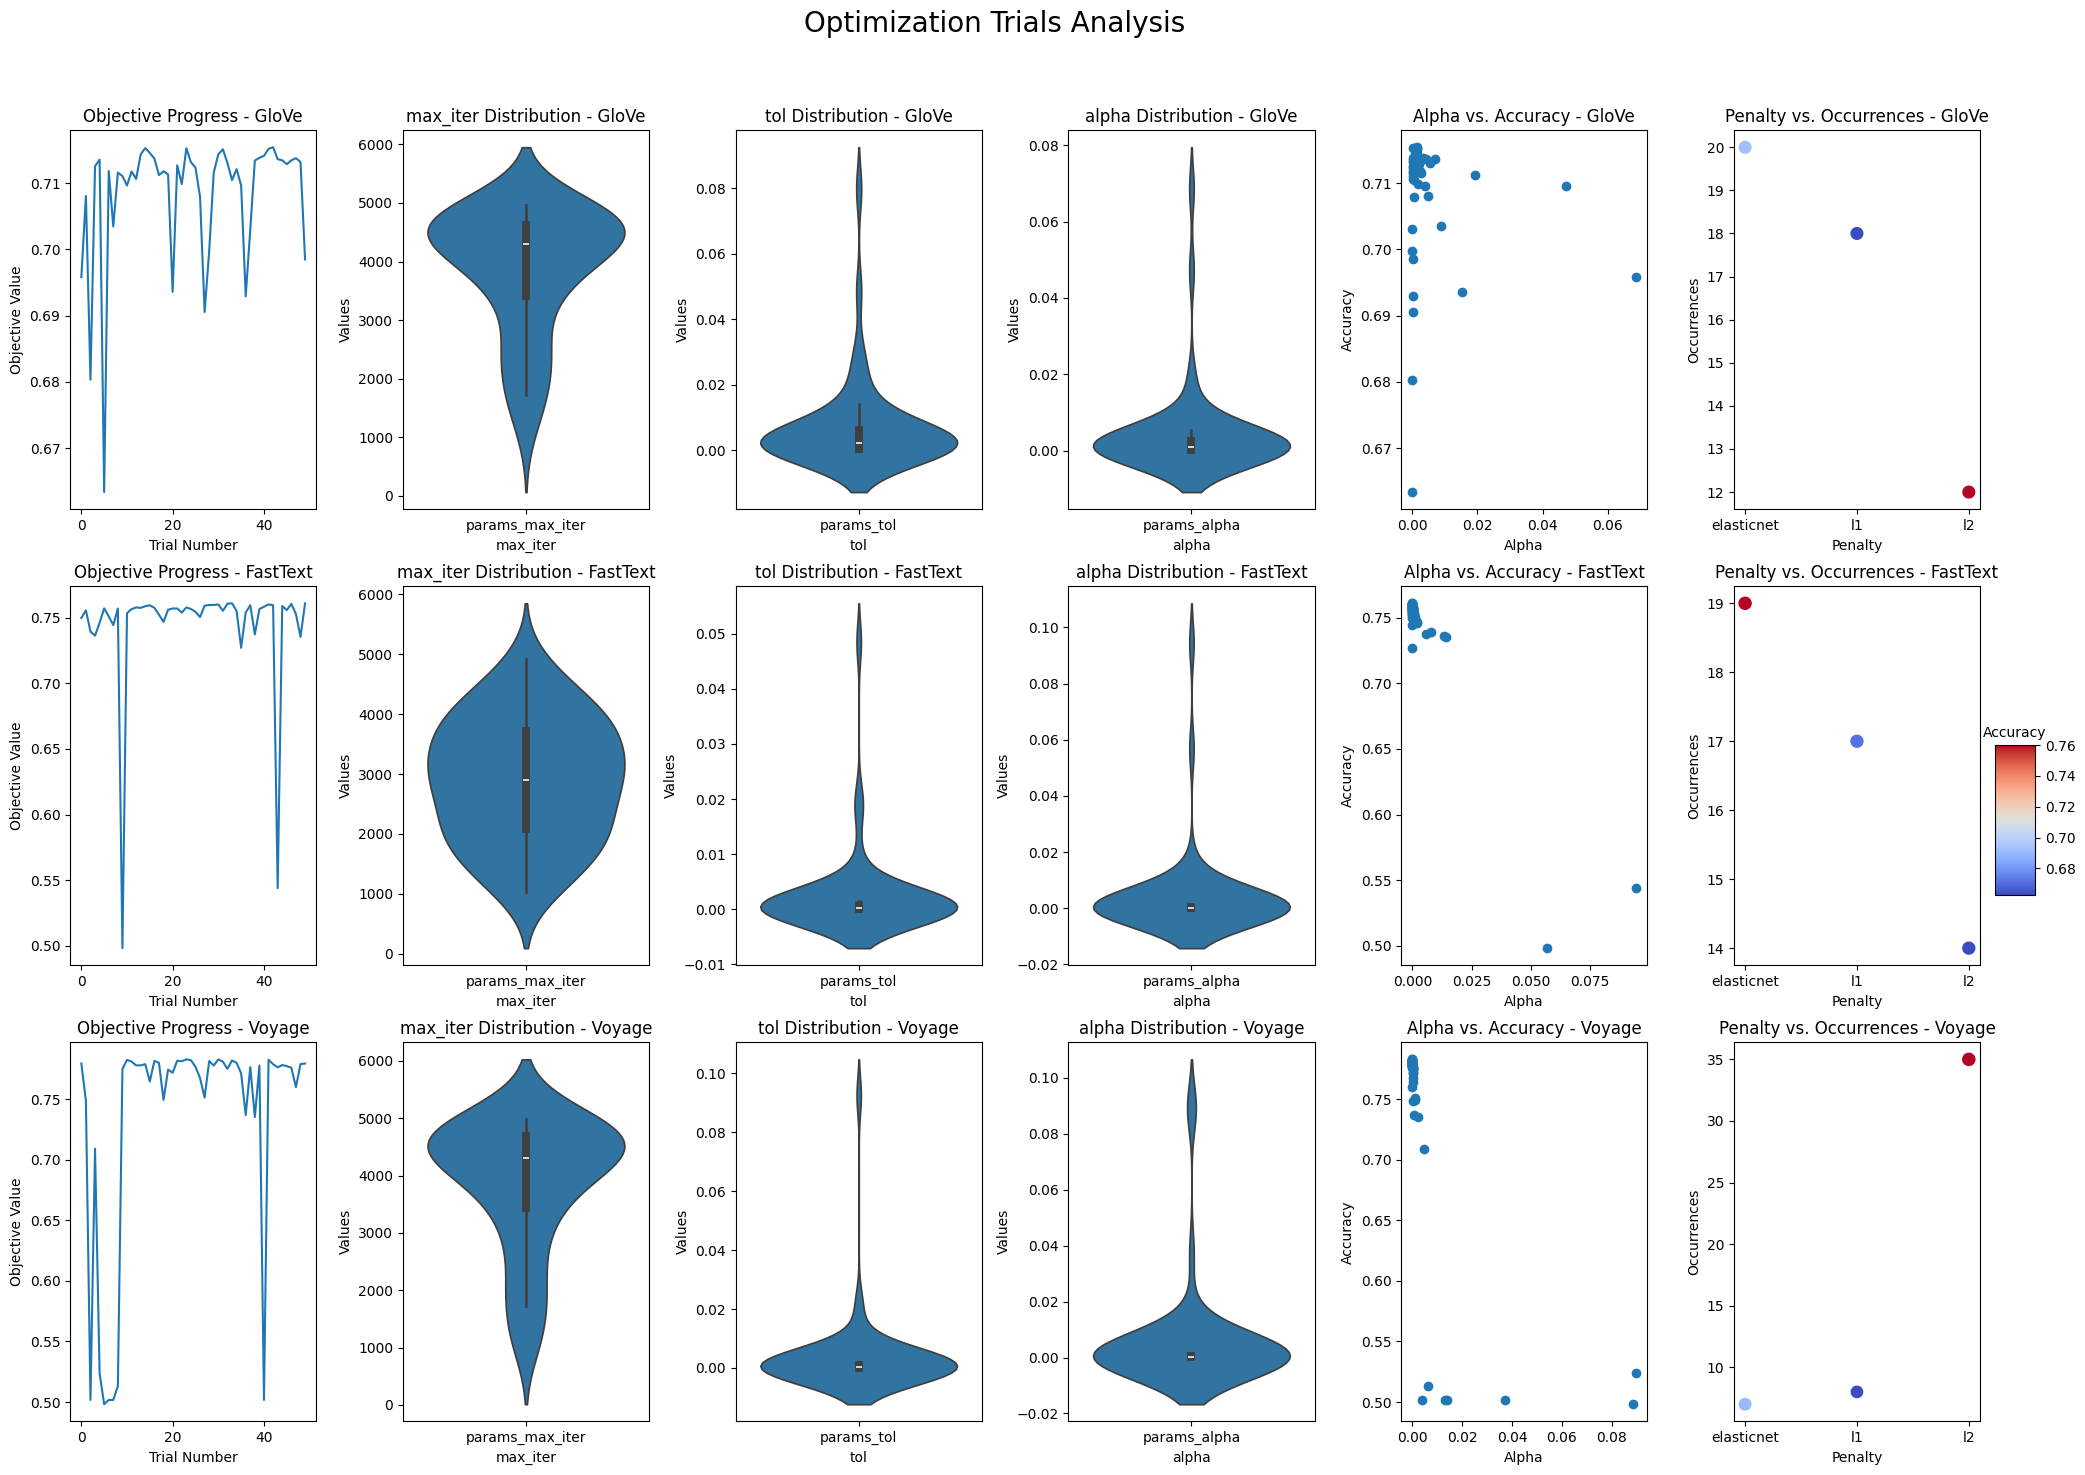

In [77]:
fig, axes = plt.subplots(3, 6, figsize=(20, 15))
fig.suptitle('Optimization Trials Analysis', fontsize=20)

for i, (df, embed) in enumerate(zip([df_svm_trials_glove, df_svm_trials_fasttext, df_svm_trials_voyage], embed_list[:-1])):
    axes[i, 0].plot(df['number'], df['value'])
    axes[i, 0].set_title(f'Objective Progress - {embed}')
    axes[i, 0].set_xlabel('Trial Number')
    axes[i, 0].set_ylabel('Objective Value')

    sns.violinplot(data=df[['params_max_iter']], ax=axes[i, 1])
    axes[i, 1].set_title(f'max_iter Distribution - {embed}')
    axes[i, 1].set_xlabel('max_iter')
    axes[i, 1].set_ylabel('Values')

    sns.violinplot(data=df[['params_tol']], ax=axes[i, 2])
    axes[i, 2].set_title(f'tol Distribution - {embed}')
    axes[i, 2].set_xlabel('tol')
    axes[i, 2].set_ylabel('Values')

    sns.violinplot(data=df[['params_alpha']], ax=axes[i, 3])
    axes[i, 3].set_title(f'alpha Distribution - {embed}')
    axes[i, 3].set_xlabel('alpha')
    axes[i, 3].set_ylabel('Values')
    
    axes[i, 4].scatter(df['params_alpha'], df['value'])
    axes[i, 4].set_title(f'Alpha vs. Accuracy - {embed}')
    axes[i, 4].set_xlabel('Alpha')
    axes[i, 4].set_ylabel('Accuracy')

    df_grouped = df.groupby('params_penalty').agg({'number': 'count', 'value': 'mean'}).reset_index()

    scatter = axes[i, 5].scatter(df_grouped['params_penalty'], df_grouped['number'], s=df_grouped['value']*100, c=df_grouped['value'], cmap='coolwarm')
    axes[i, 5].set_title(f'Penalty vs. Occurrences - {embed}')
    axes[i, 5].set_xlabel('Penalty')
    axes[i, 5].set_ylabel('Occurrences')

cbar = fig.colorbar(scatter, ax=axs, cax=fig.add_axes([1, 0.39, 0.02, 0.1]))
cbar.orientation = 'horizontal'
cbar.ax.set_title('Accuracy', fontdict={'fontsize': 10})
plt.tight_layout()
plt.subplots_adjust(top=0.9)
#plt.savefig('images/svm_trials.png')
plt.show()

### The figure above summarizes the hyperparameter search done with Optuna. For each embedding model, it shows the accuracy in relation to the trials, the distribution of the parameters max_iter, tol, and alpha, as well as alpha in relation to accuracy, and the number of occurrences of each penalty with the average score visualized by color. We can notice that for FastText, the distribution of max_iter is less concentrated than for the other two. We can also see that they all converge towards a fairly low alpha value. Finally, we observe that they do not tend towards the same penalties. Glove and FastText have favored elasticnet more, while Voyage has significantly more often opted for the l2 penalty. However, Glove and Voyage achieved better results with the l2 penalty, whereas the best for FastText seems to be elasticnet

## Now let's look at the metrics on the test set and save them in our dictionary